Credit to Siddharth.

# Loading Libraries

In [1]:
# *- encoding: utf-8 -*-
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold

import numpy as np
import pandas as pd

import os
import json
from pathlib import Path
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np
from sklearn.model_selection import GridSearchCV

import pdb

# Set Paths

In [2]:
data_path = Path('/kaggle/input/abstraction-and-reasoning-challenge/')
training_path = data_path / 'training'
evaluation_path = data_path / 'evaluation'
test_path = data_path / 'test'

# Plotting functions

In [3]:
def plot_result(test_input, test_prediction,
                input_shape):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 2, figsize=(15,15))
    test_input = test_input.reshape(input_shape[0],input_shape[1])
    axs[0].imshow(test_input, cmap=cmap, norm=norm)
    axs[0].axis('off')
    axs[0].set_title('Actual Target')
    test_prediction = test_prediction.reshape(input_shape[0],input_shape[1])
    axs[1].imshow(test_prediction, cmap=cmap, norm=norm)
    axs[1].axis('off')
    axs[1].set_title('Model Prediction')
    plt.tight_layout()
    plt.show()
    
def plot_test(test_prediction, task_name):
    """
    Plots the first train and test pairs of a specified task,
    using same color scheme as the ARC app
    """
    cmap = colors.ListedColormap(
        ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
         '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    fig, axs = plt.subplots(1, 1, figsize=(15,15))
    axs.imshow(test_prediction, cmap=cmap, norm=norm)
    axs.axis('off')
    axs.set_title(f'Test Prediction {task_name}')
    plt.tight_layout()
    plt.show()

# For flattening 2D numpy arrays

In [4]:
# https://www.kaggle.com/inversion/abstraction-and-reasoning-starter-notebook
def flattener(pred):
    str_pred = str([row for row in pred])
    str_pred = str_pred.replace(', ', '')
    str_pred = str_pred.replace('[[', '|')
    str_pred = str_pred.replace('][', '|')
    str_pred = str_pred.replace(']]', '|')
    return str_pred

In [5]:
sample_sub = pd.read_csv(data_path/'sample_submission.csv')
sample_sub = sample_sub.set_index('output_id')
sample_sub.head()

,output
output_id,
00576224_0,|32|78| |32|78| |00|00|
009d5c81_0,|00000000000000|00000888888888|00000800080808|...
00dbd492_0,|00000000000222220000|02222222220200020000|020...
03560426_0,|0000000000|0000000000|0000000000|0000000000|0...
05a7bcf2_0,|000000000020000000080000000000|00000000002220...


# Extract neighbourhood Features

In [6]:
def get_moore_neighbours(color, cur_row, cur_col, nrows, ncols):

    if cur_row<=0: top = -1
    else: top = color[cur_row-1][cur_col]
        
    if cur_row>=nrows-1: bottom = -1
    else: bottom = color[cur_row+1][cur_col]
        
    if cur_col<=0: left = -1
    else: left = color[cur_row][cur_col-1]
        
    if cur_col>=ncols-1: right = -1
    else: right = color[cur_row][cur_col+1]
        
    return top, bottom, left, right

def get_tl_tr(color, cur_row, cur_col, nrows, ncols):
        
    if cur_row==0:
        top_left = -1
        top_right = -1
    else:
        if cur_col==0: top_left=-1
        else: top_left = color[cur_row-1][cur_col-1]
        if cur_col==ncols-1: top_right=-1
        else: top_right = color[cur_row-1][cur_col+1]   
        
    return top_left, top_right

# Make features for each train sample

In [7]:
def features(task, mode='train'):
    cur_idx = 0
    num_train_pairs = len(task[mode])
    total_inputs = sum([len(task[mode][i]['input'])*len(task[mode][i]['input'][0]) for i in range(num_train_pairs)])
    feat = np.zeros((total_inputs,nfeat))
    target = np.zeros((total_inputs,), dtype=np.int)
    
    global local_neighb
    for task_num in range(num_train_pairs):
        input_color = np.array(task[mode][task_num]['input'])
        target_color = task[mode][task_num]['output']
        nrows, ncols = len(task[mode][task_num]['input']), len(task[mode][task_num]['input'][0])

        target_rows, target_cols = len(task[mode][task_num]['output']), len(task[mode][task_num]['output'][0])
        
        if (target_rows!=nrows) or (target_cols!=ncols):
            print('Number of input rows:',nrows,'cols:',ncols)
            print('Number of target rows:',target_rows,'cols:',target_cols)
            not_valid=1
            return None, None, 1

        for i in range(nrows):
            for j in range(ncols):
                feat[cur_idx,0] = i
                feat[cur_idx,1] = j
                feat[cur_idx,2] = input_color[i][j]
                feat[cur_idx,3:7] = get_moore_neighbours(input_color, i, j, nrows, ncols)
                feat[cur_idx,7:9] = get_tl_tr(input_color, i, j, nrows, ncols)
                feat[cur_idx,9] = len(np.unique(input_color[i,:]))
                feat[cur_idx,10] = len(np.unique(input_color[:,j]))
                feat[cur_idx,11] = (i+j)
                feat[cur_idx,12] = len(np.unique(input_color[i-local_neighb:i+local_neighb,
                                                             j-local_neighb:j+local_neighb]))
        
                target[cur_idx] = target_color[i][j]
                cur_idx += 1
            
    return feat, target, 0

# Training and Prediction

In [8]:
param_grid = {
    "xgb__n_estimators": [10],
    "xgb__learning_rate": [0.1],
    "xgb__early_stopping_rounds": np.array((50, 1000))
}

Number of input rows: 2 cols: 2
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/00576224.json

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    5.4s remaining:    1.3s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    5.6s finished


Made predictions for  009d5c81


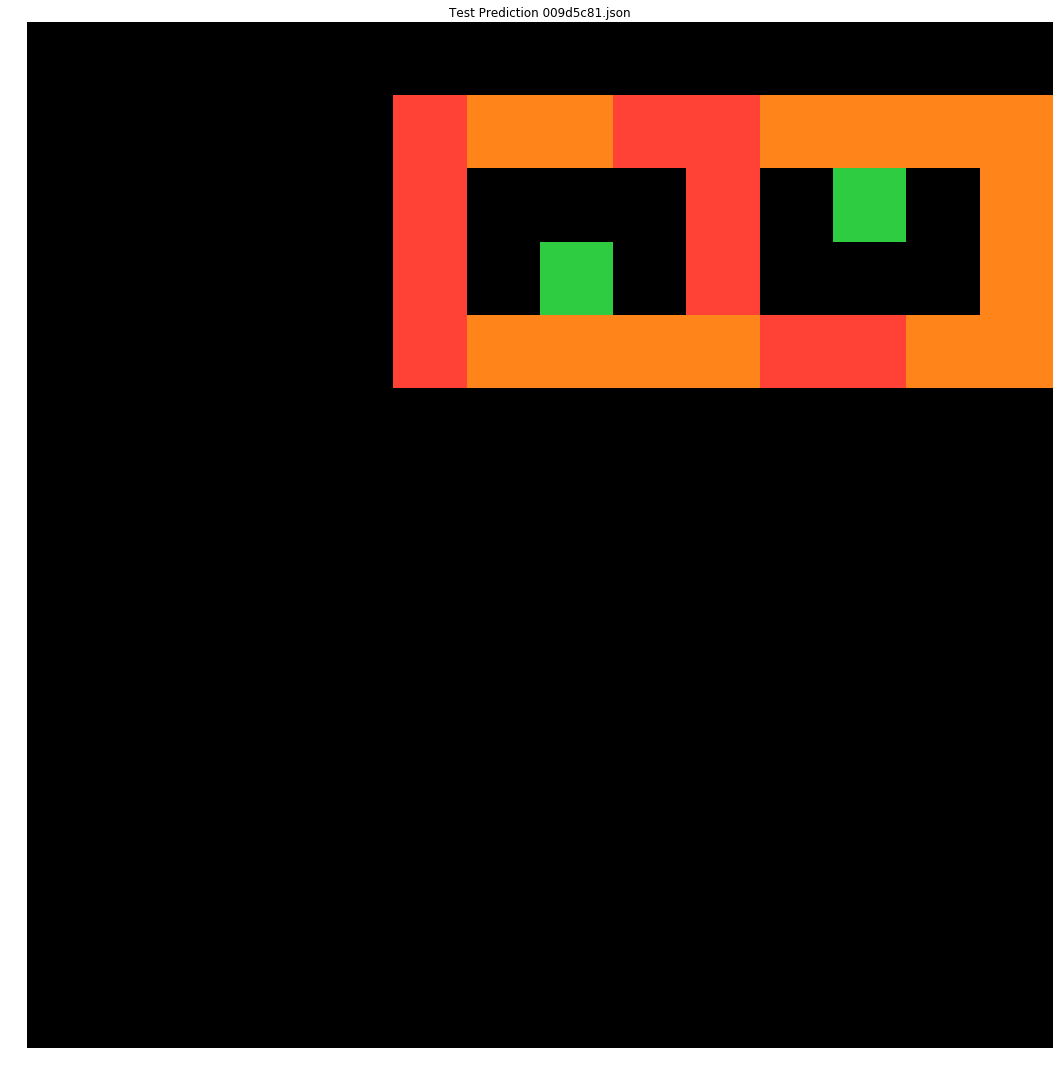

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.2s finished


Made predictions for  00dbd492


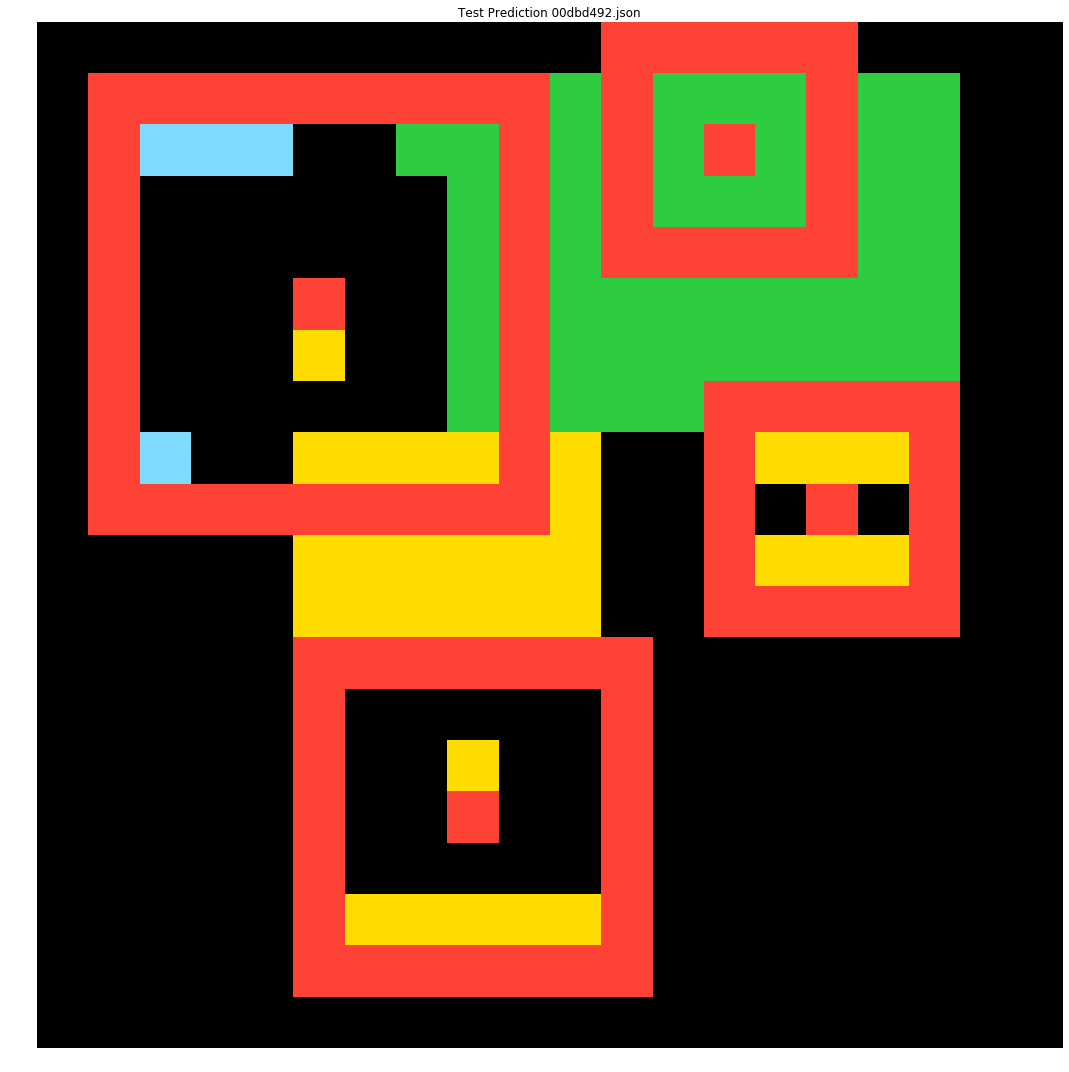

Fitting 10 folds for each of 2 candidates, totalling 20 fits


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    1.0s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.2s finished


Made predictions for  03560426


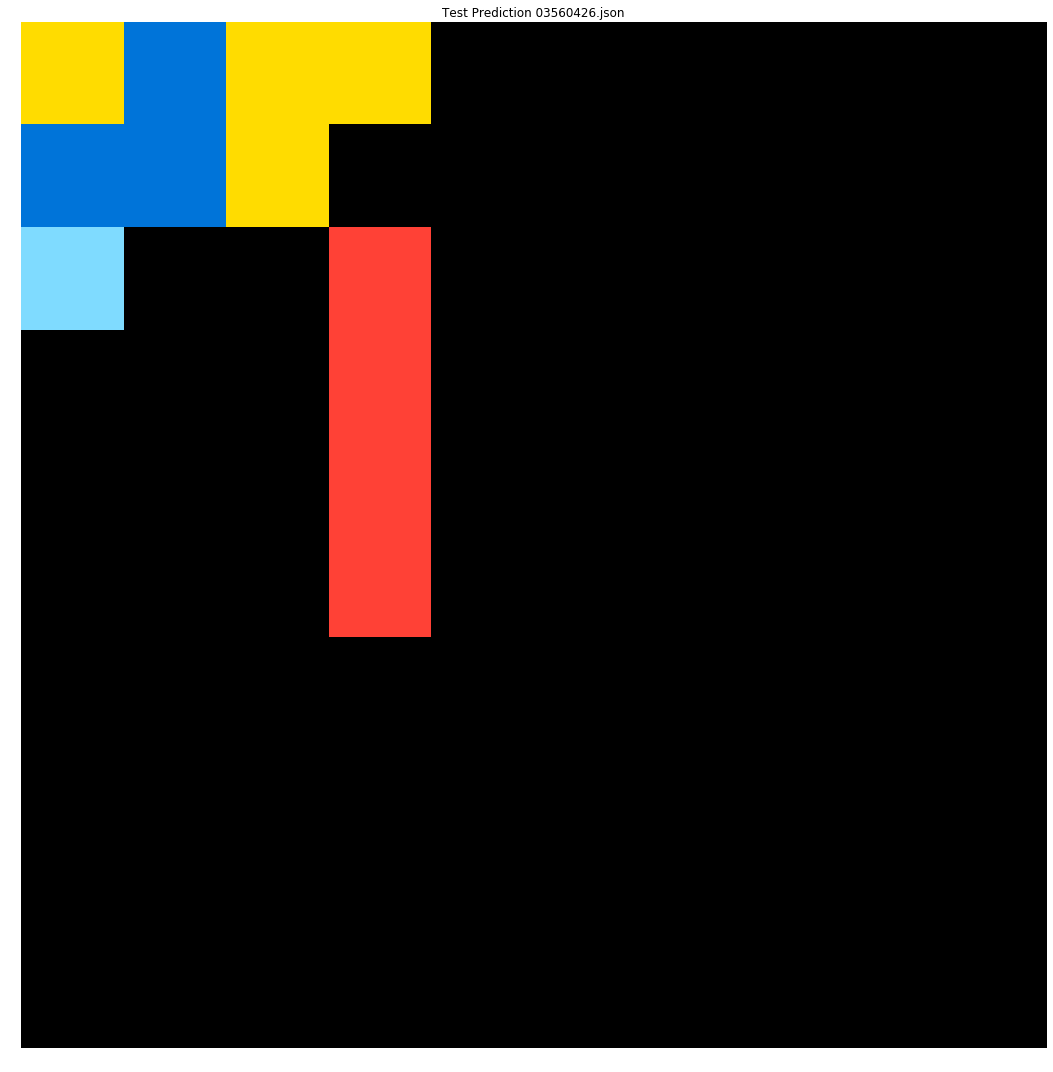

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    3.9s remaining:    1.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    4.7s finished


Made predictions for  05a7bcf2


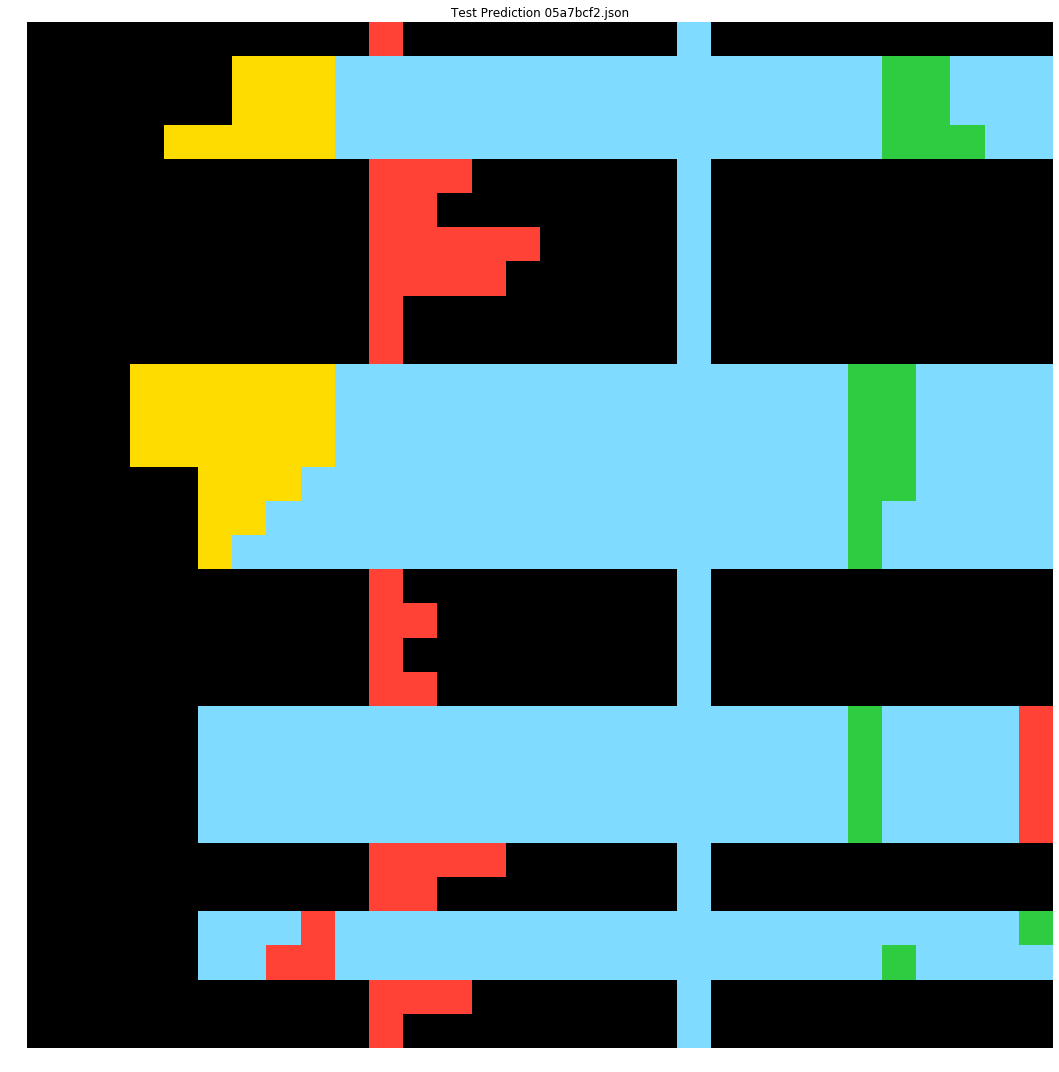

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    3.0s remaining:    0.7s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    3.4s finished


Made predictions for  0607ce86


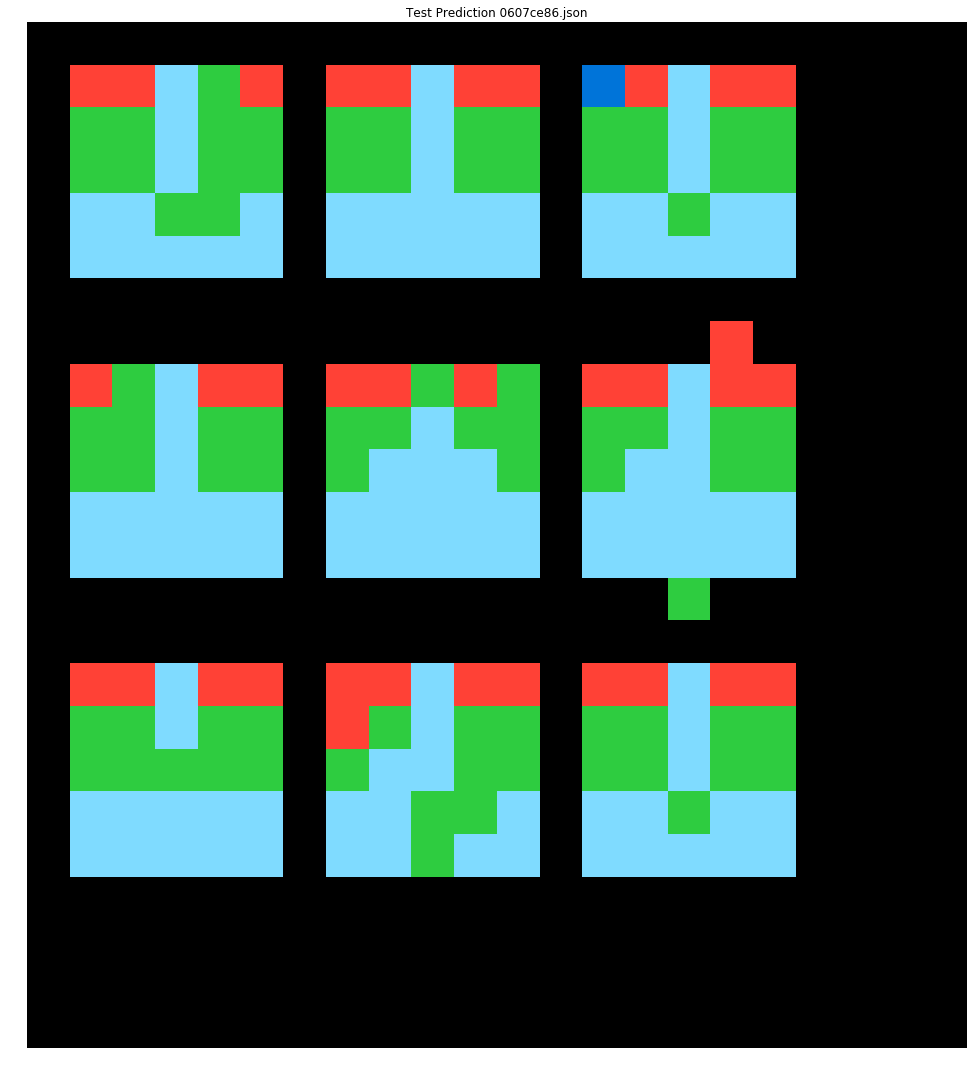

Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/0692e18c.json

set(val_target) {0, 3, 4, 7, 8, 9}
set(train_target) {0, 2, 3, 5, 6, 8}
Number of colors are not same
cant handle new colors. skipping
Fitting 10 folds for each of 2 candidates, totalling 20 fits


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.1s finished


Made predictions for  08573cc6


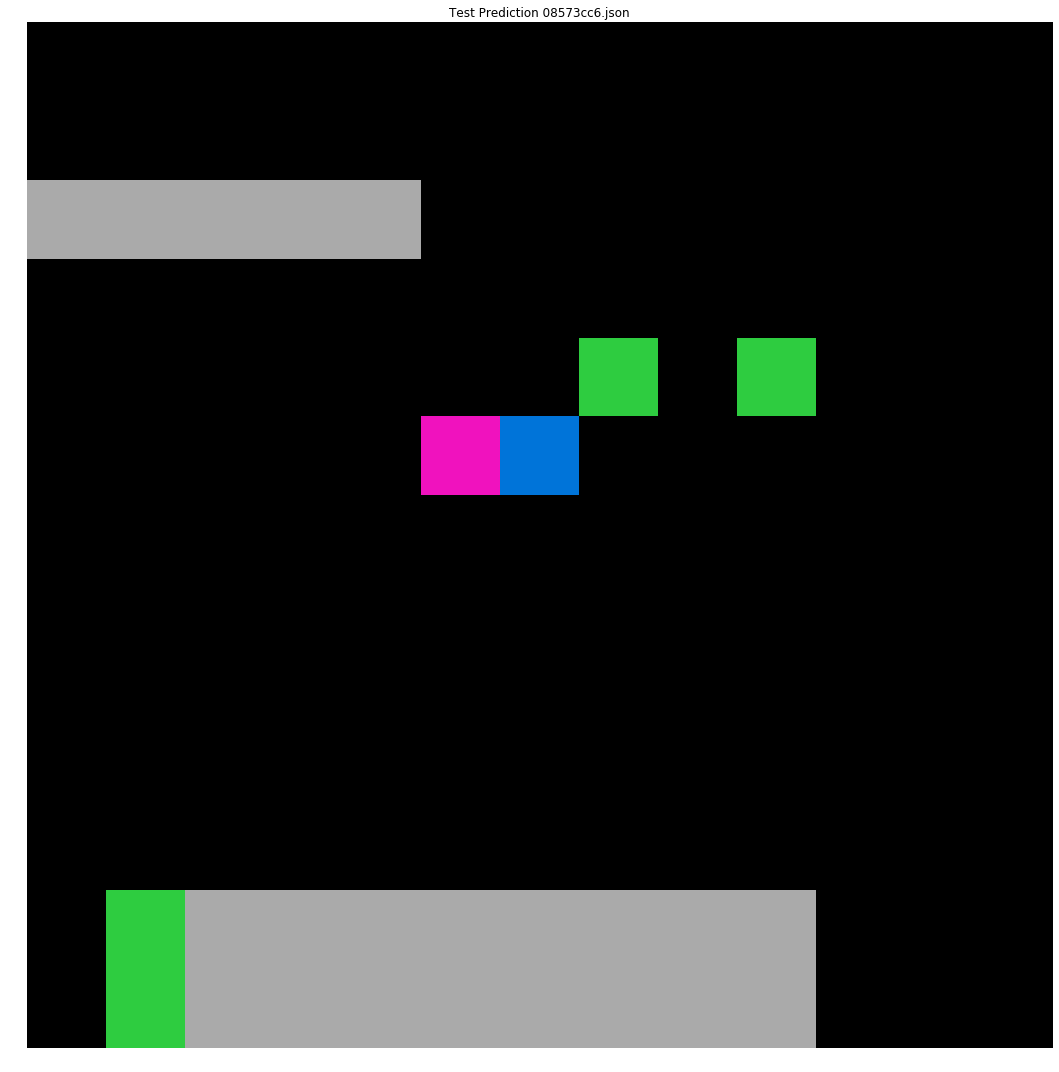

Number of input rows: 30 cols: 30
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/0934a4d8.json

set(val_target) {0, 1, 3, 4, 6}
set(train_target) {0, 1, 2, 3, 4}
Number of colors are not same
cant handle new colors. skipping
Number of input rows: 30 cols: 30
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/0a1d4ef5.json

set(val_target) {0, 1, 2, 3, 4}
set(train_target) {0, 1, 2, 3}
Number of colors are not same
cant handle new colors. skipping
Fitting 10 folds for each of 2 candidates, totalling 20 fits


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.6s finished


Made predictions for  0b17323b


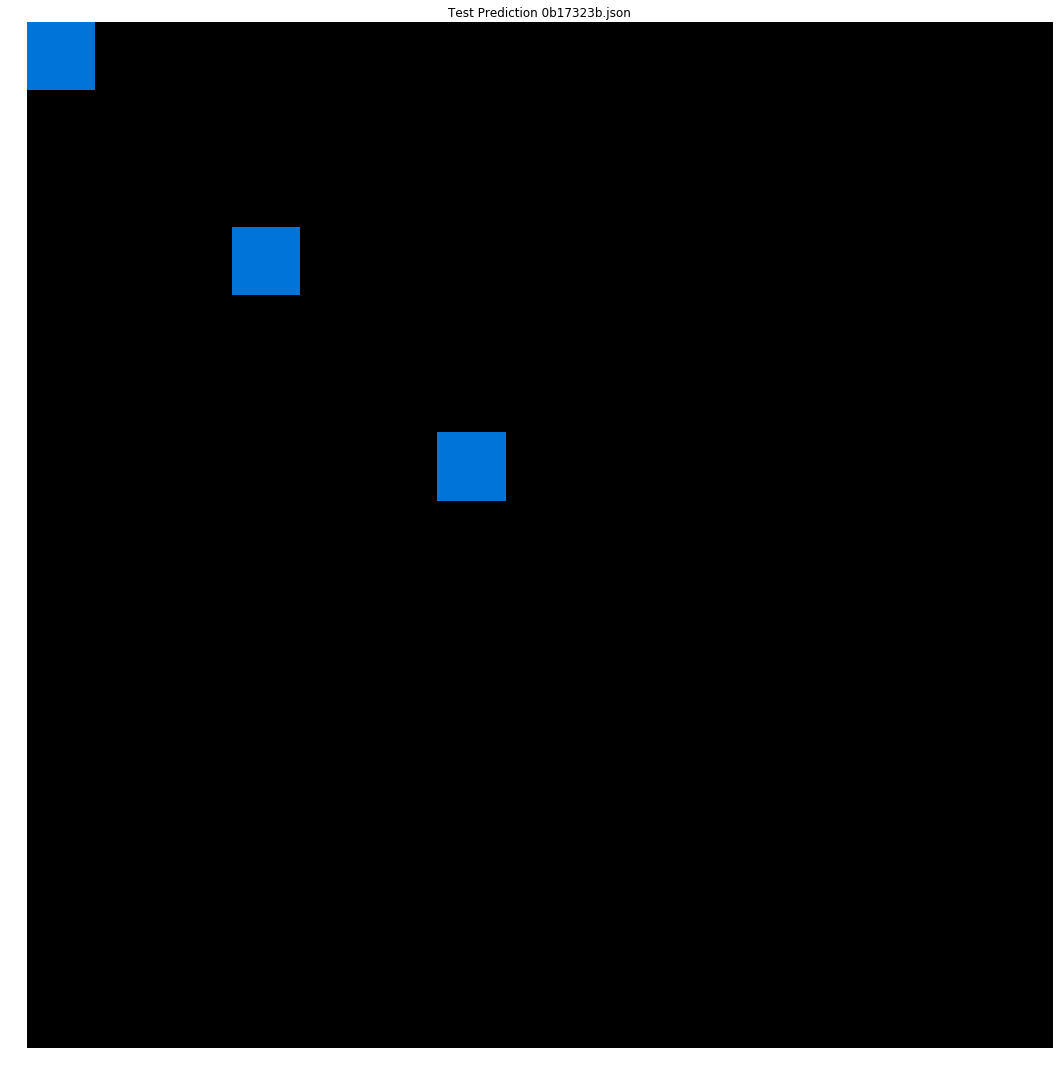

Number of input rows: 12 cols: 13
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/0bb8deee.json

set(val_target) {0, 4, 6, 7, 9}
set(train_target) {0, 1, 2, 3, 4, 7, 8}
Number of colors are not same
cant handle new colors. skipping
Number of input rows: 3 cols: 4
Number of target rows: 6 cols: 8
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/0c786b71.json

Number of input rows: 13 cols: 4
Number of target rows: 6 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/0c9aba6e.json

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    1.0s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.1s finished


Made predictions for  0d87d2a6


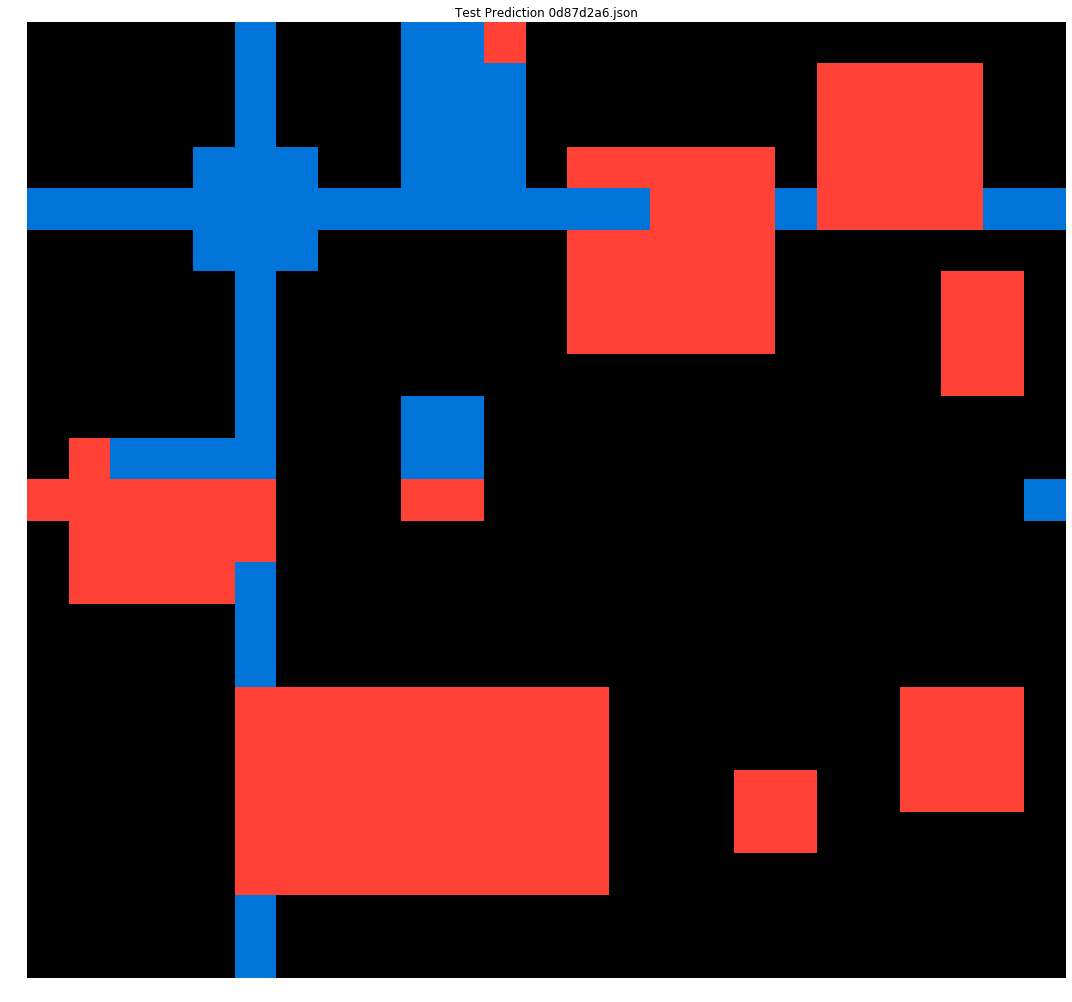

Fitting 10 folds for each of 2 candidates, totalling 20 fits


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.2s finished


Made predictions for  0e671a1a


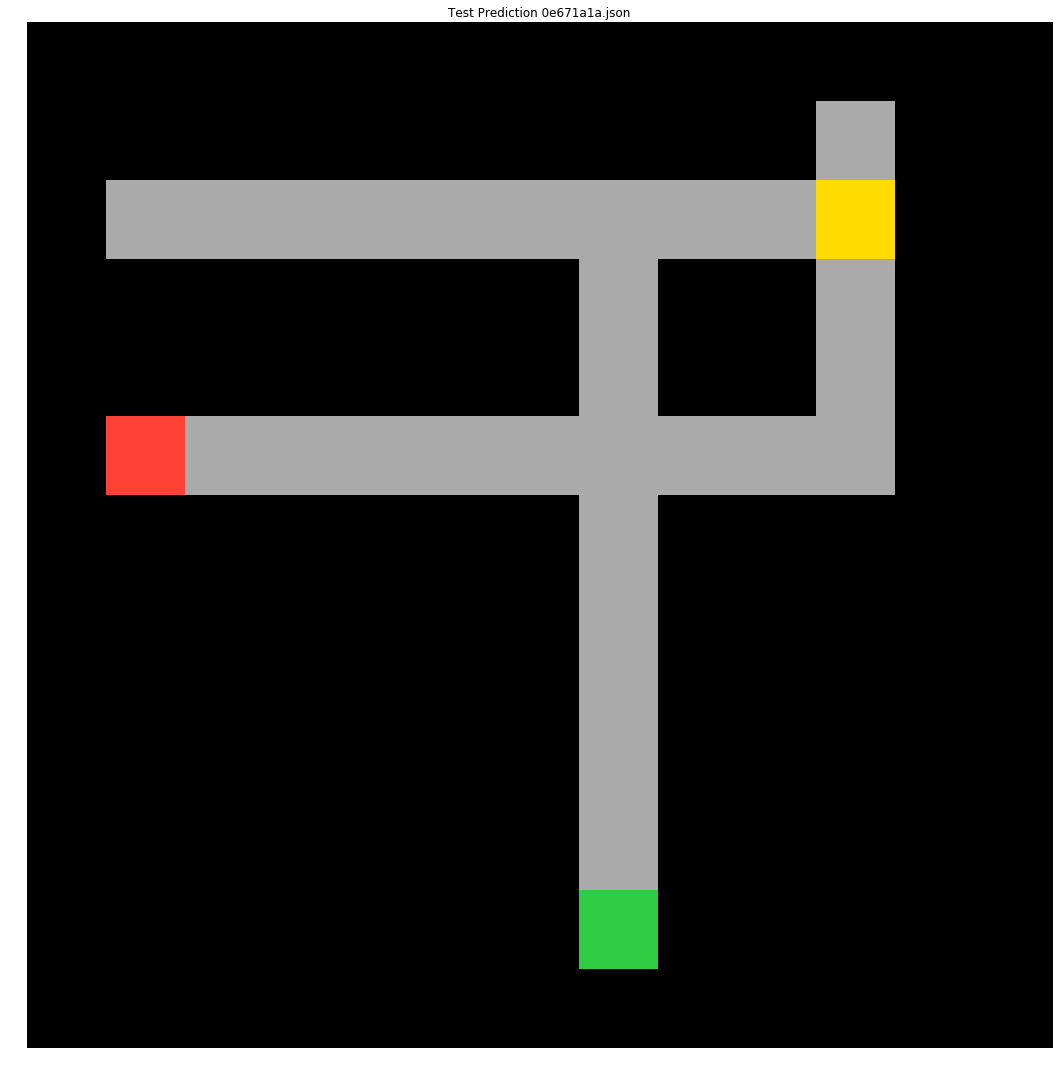

set(val_target) {0, 9, 2, 3}
set(train_target) {0, 1, 2, 3, 6, 7, 8}
Number of colors are not same
cant handle new colors. skipping
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.3s finished


Made predictions for  103eff5b


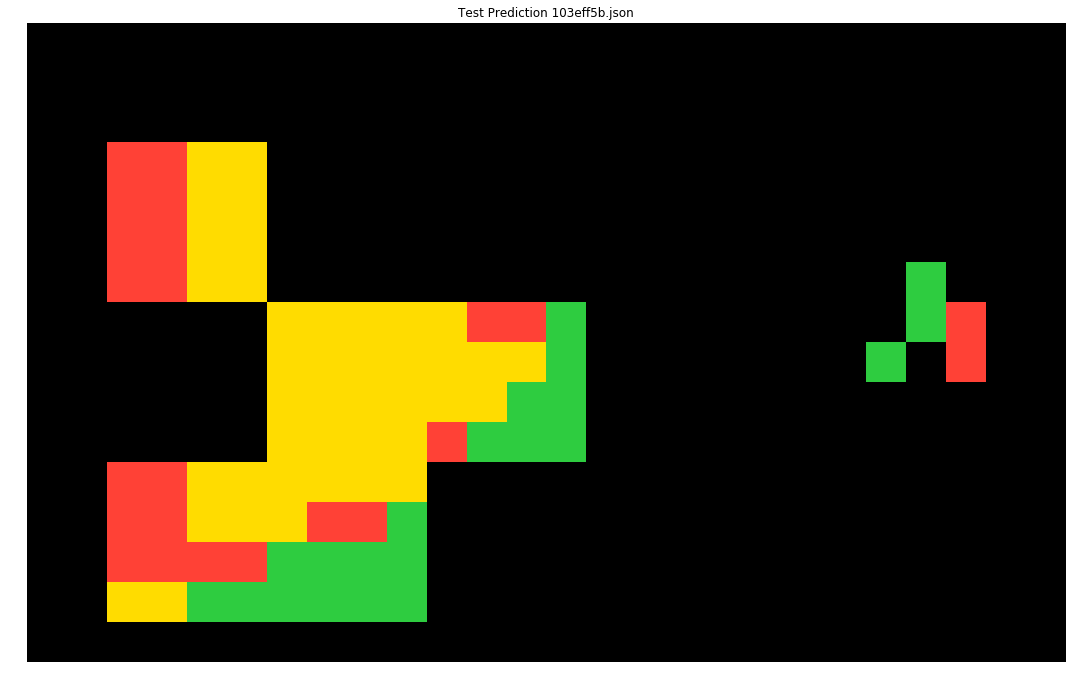

set(val_target) {0, 2, 5, 6, 8}
set(train_target) {0, 1, 2, 3, 5}
Number of colors are not same
cant handle new colors. skipping
Fitting 10 folds for each of 2 candidates, totalling 20 fits


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.2s finished


Made predictions for  12422b43


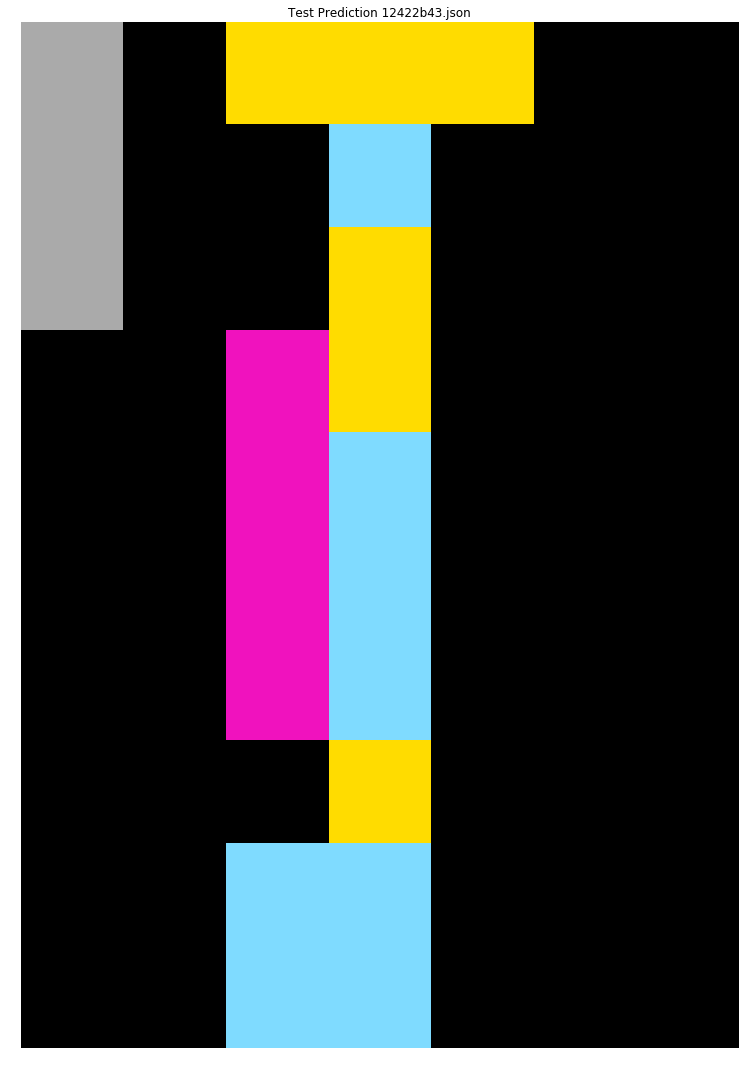

Number of input rows: 11 cols: 14
Number of target rows: 3 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/12997ef3.json

Fitting 10 folds for each of 2 candidates, totalling 20 fits


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.7s finished


Made predictions for  12eac192


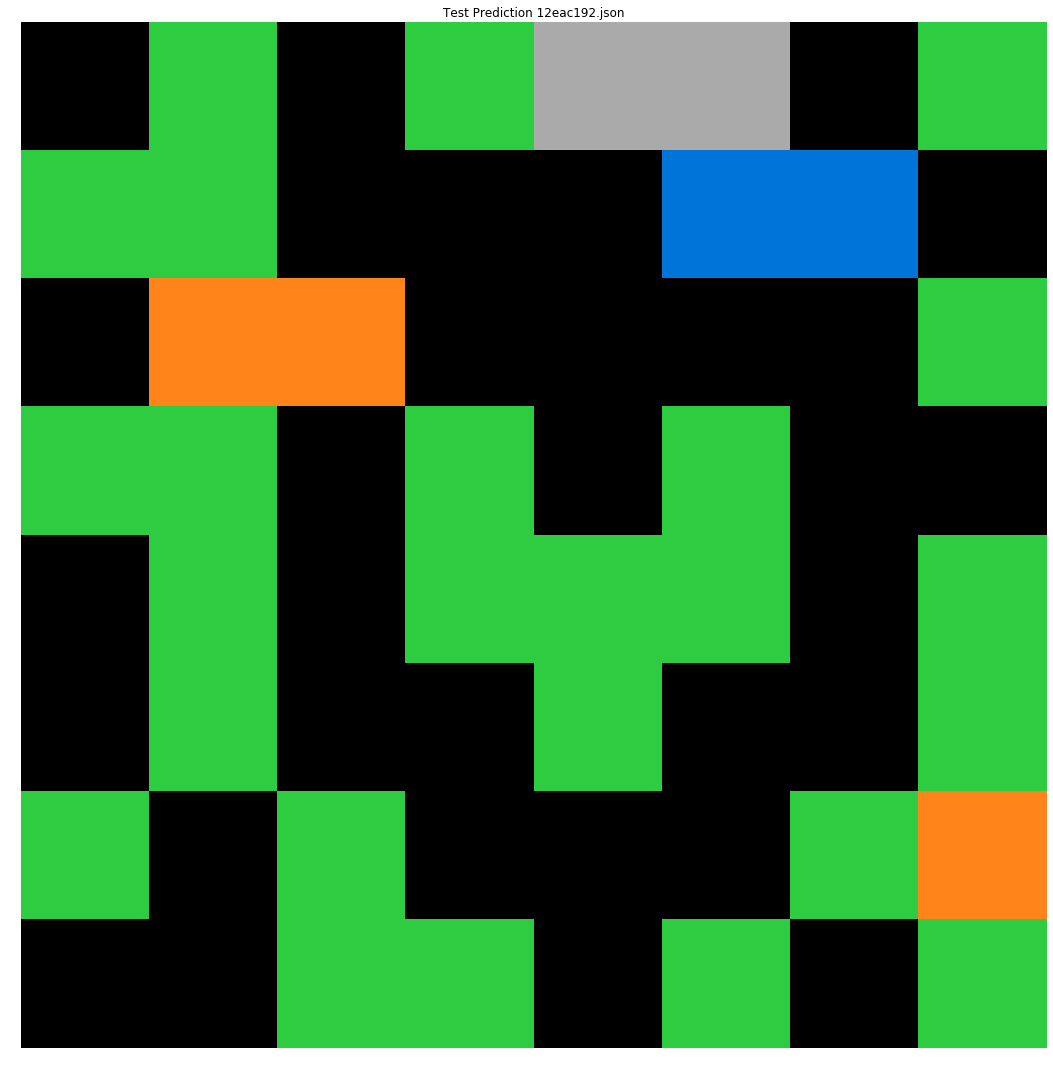

Number of input rows: 7 cols: 15
Number of target rows: 7 cols: 7
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/136b0064.json

set(val_target) {0, 2, 3, 5, 6}
set(train_target) {0, 2, 3, 4, 5, 7, 8}
Number of colors are not same
cant handle new colors. skipping
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.7s finished


Made predictions for  137f0df0


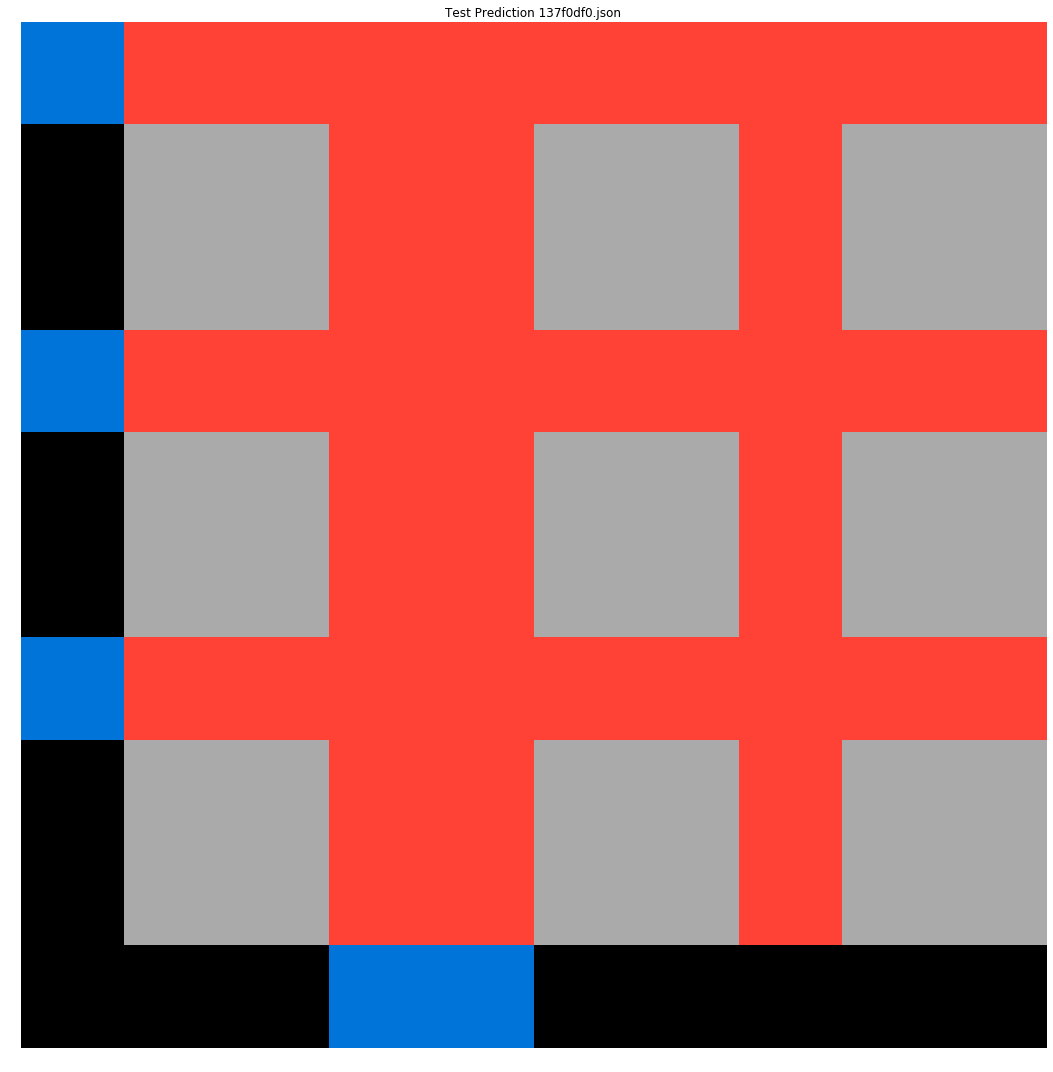

set(val_target) {1, 2, 3, 7}
set(train_target) {1, 2, 3, 8, 9}
Number of colors are not same
cant handle new colors. skipping
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    1.4s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.6s finished


Made predictions for  14754a24


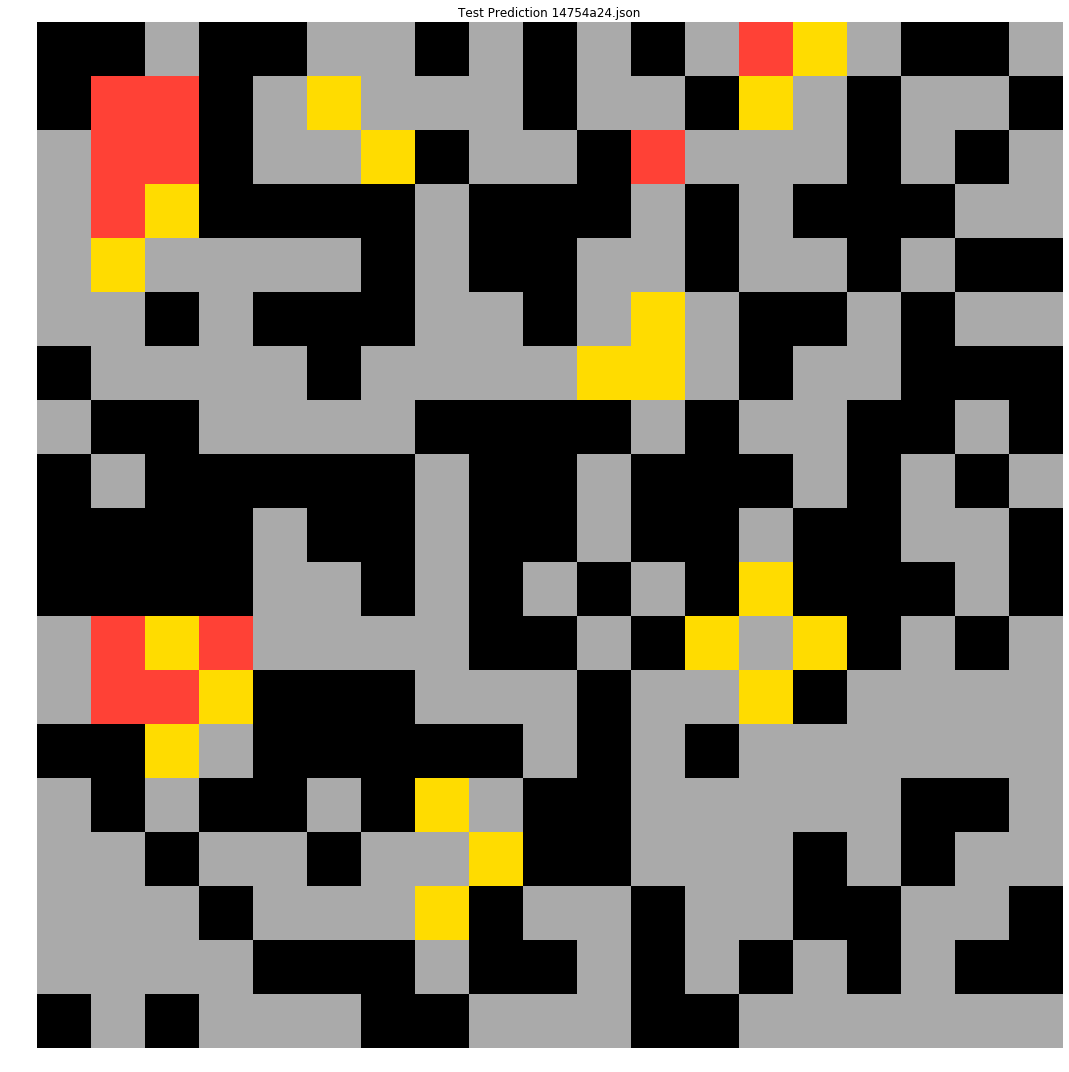

set(val_target) {0, 1, 3, 4}
set(train_target) {0, 1, 4, 6, 8}
Number of colors are not same
cant handle new colors. skipping
set(val_target) {0, 1, 2, 4}
set(train_target) {0, 2, 3, 4, 8}
Number of colors are not same
cant handle new colors. skipping
Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/15696249.json

set(val_target) {0, 1, 2, 3, 4, 6, 8}
set(train_target) {0, 1, 2, 3, 4}
Number of colors are not same
cant handle new colors. skipping
Fitting 10 folds for each of 2 candidates, totalling 20 fits


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    2.4s remaining:    0.6s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    2.8s finished


Made predictions for  17b80ad2


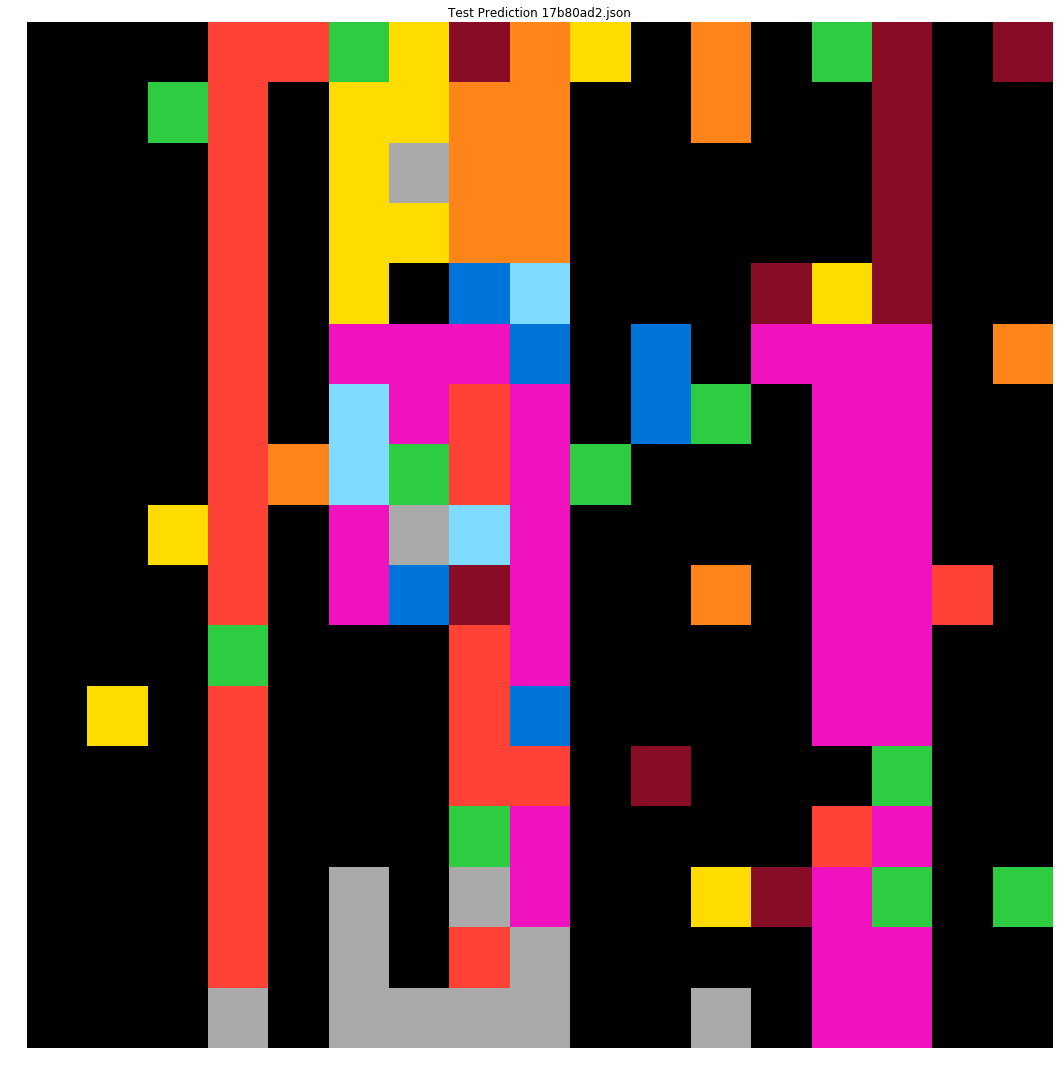

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.6s finished


Made predictions for  17cae0c1


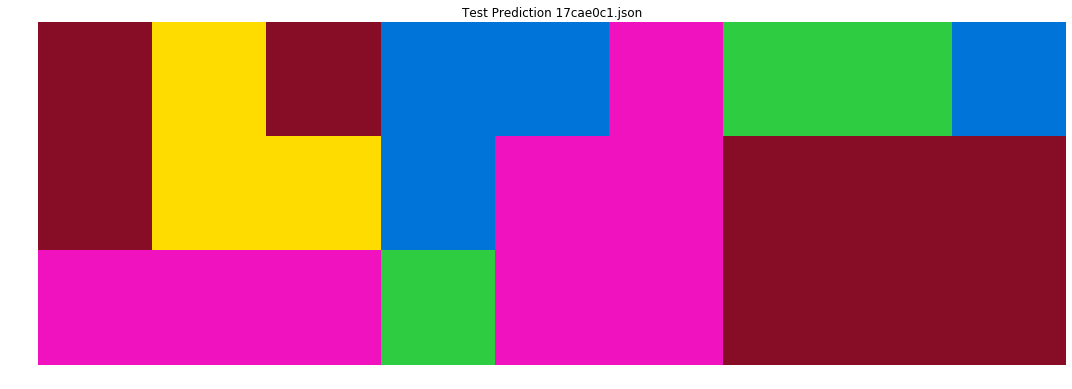

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.2s finished


Made predictions for  18419cfa


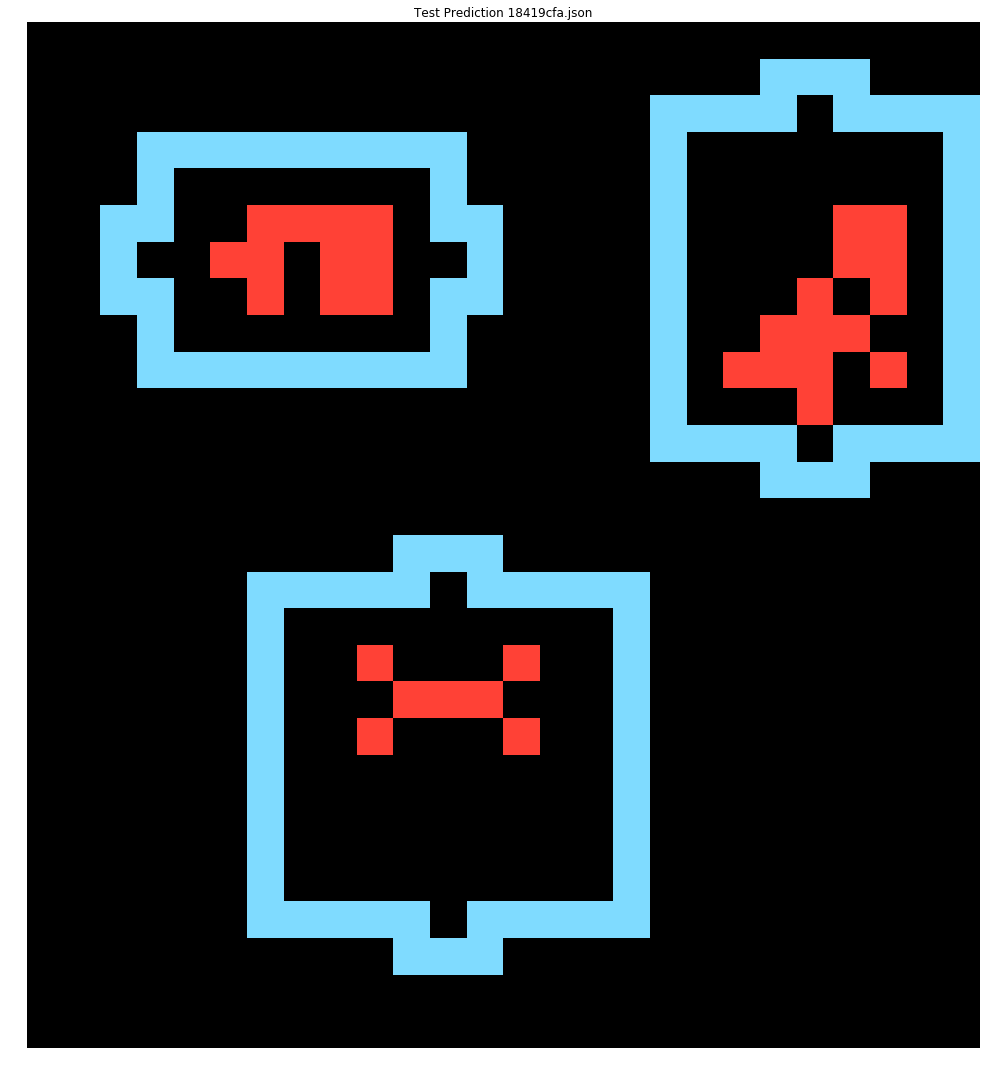

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    2.9s remaining:    0.7s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    3.5s finished


Made predictions for  184a9768


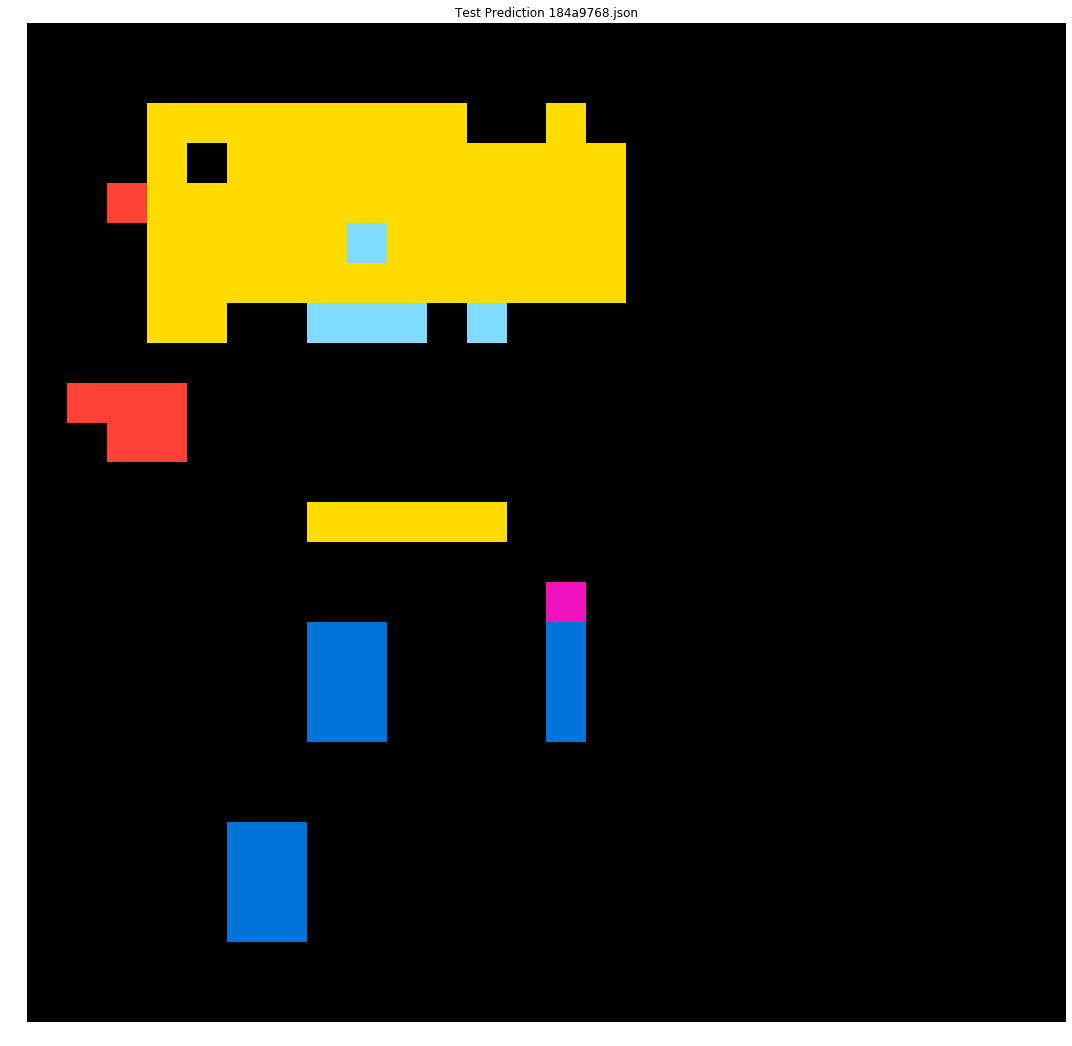

Number of input rows: 5 cols: 13
Number of target rows: 5 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/195ba7dc.json

Number of input rows: 23 cols: 23
Number of target rows: 7 cols: 7
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/1990f7a8.json

Number of input rows: 13 cols: 15
Number of target rows: 2 cols: 2
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/19bb5feb.json

Number of input rows: 8 cols: 12
Number of target rows: 1 cols: 1
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/1a2e2828.json

Number of input rows: 19 cols: 13
Number of target rows: 6 cols: 7
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/1a6449f1.json

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    0.9s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.0s finished


Made predictions for  1acc24af


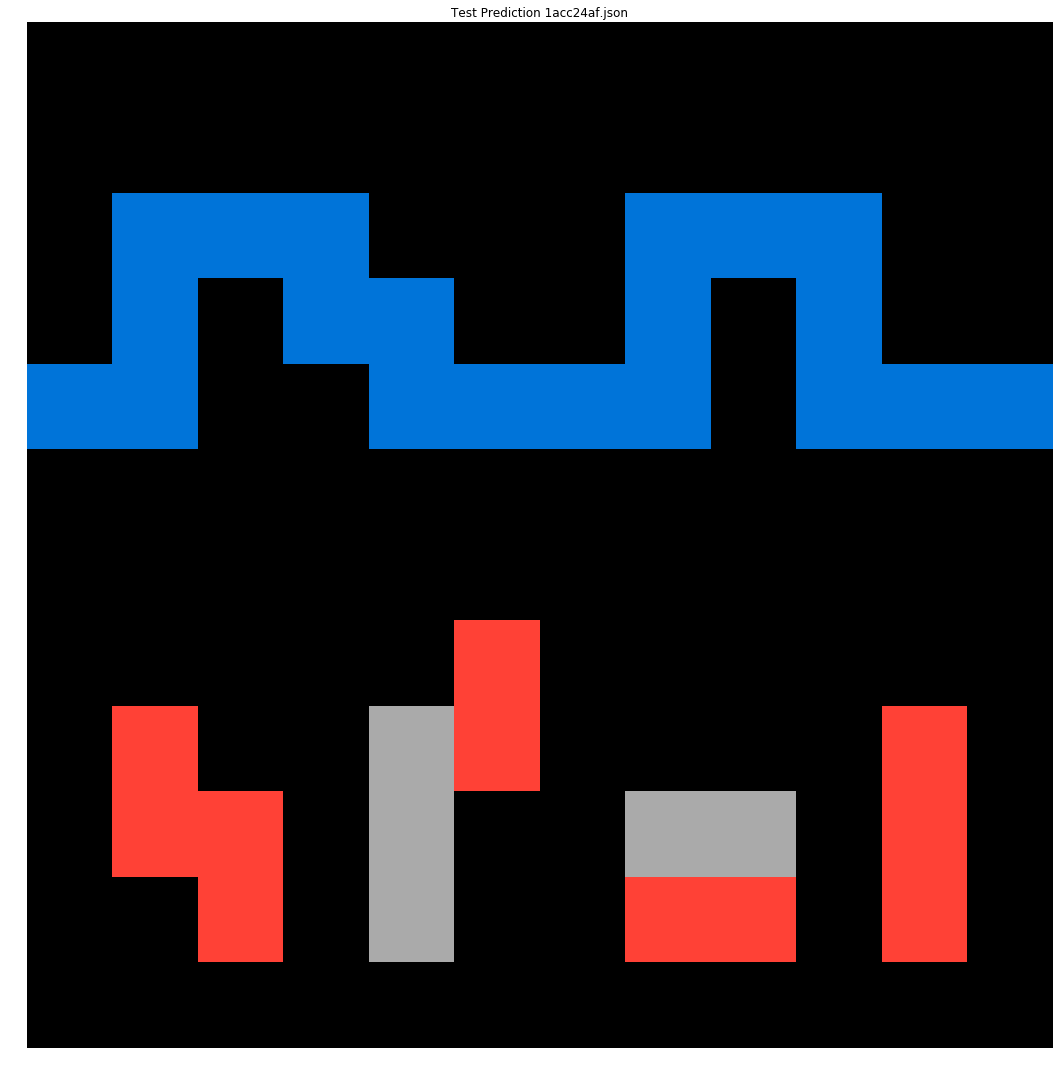

set(val_target) {0, 1, 4, 5, 6}
set(train_target) {0, 2, 3, 4, 5}
Number of colors are not same
cant handle new colors. skipping
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    0.2s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished


Made predictions for  1c0d0a4b


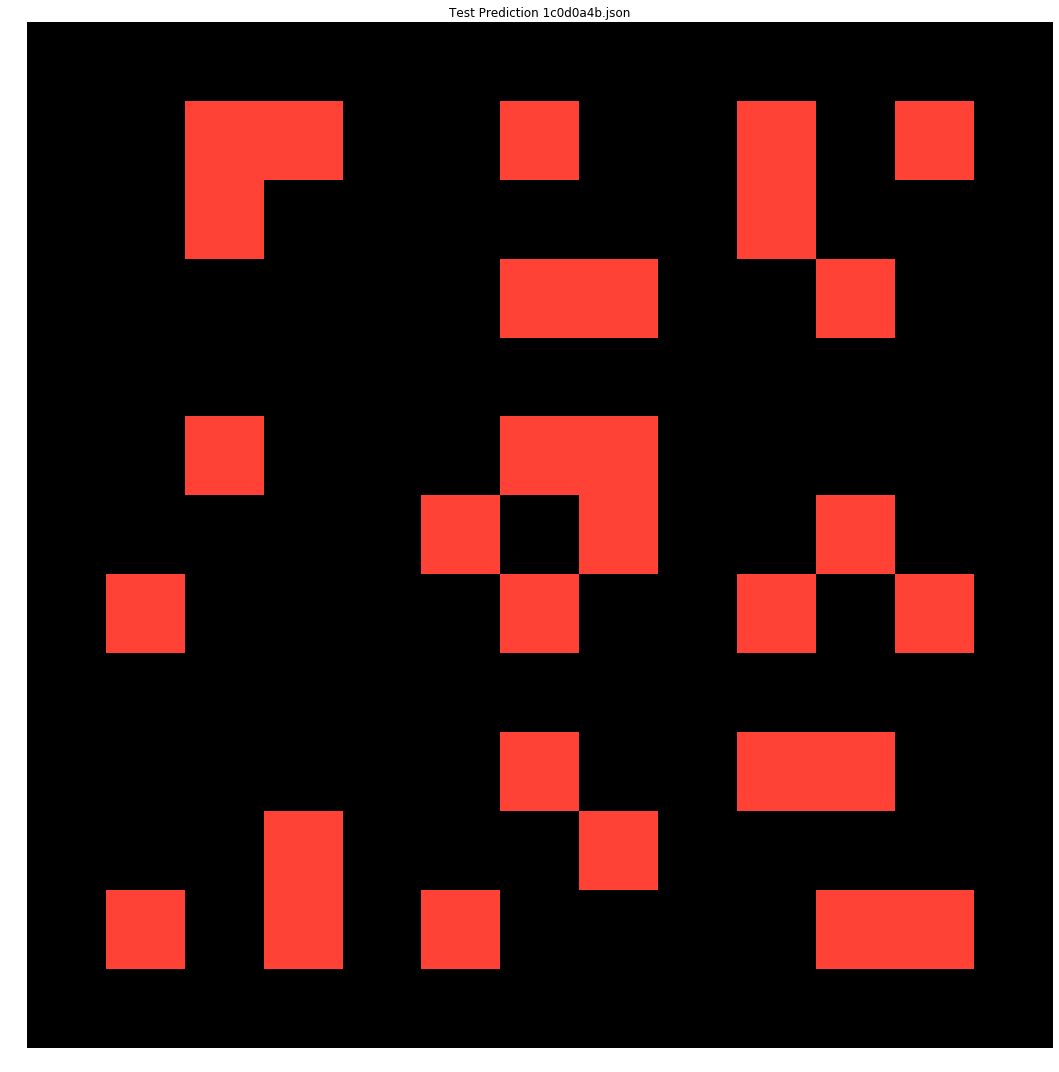

set(val_target) {0, 8}
set(train_target) {0, 2, 3, 5}
Number of colors are not same
cant handle new colors. skipping
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    3.0s remaining:    0.7s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    3.5s finished


Made predictions for  1d0a4b61


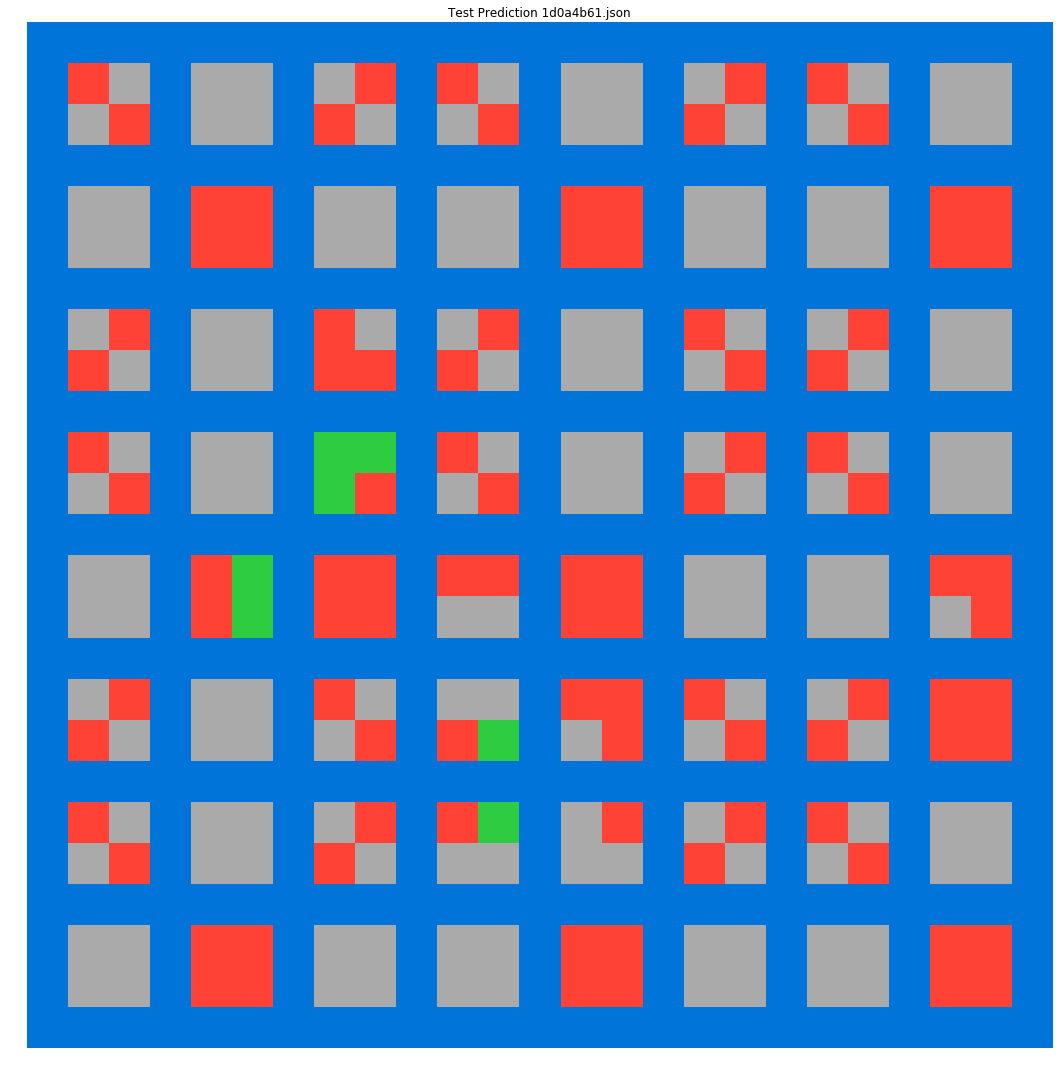

set(val_target) {0, 2, 4, 5, 6, 8}
set(train_target) {0, 1, 2, 3, 5, 6, 7, 8}
Number of colors are not same
cant handle new colors. skipping
set(val_target) {0, 2, 3, 4, 5, 6}
set(train_target) {0, 2, 3, 4, 5}
Number of colors are not same
cant handle new colors. skipping
Fitting 10 folds for each of 2 candidates, totalling 20 fits


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    1.9s remaining:    0.5s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    2.3s finished


Made predictions for  1e81d6f9


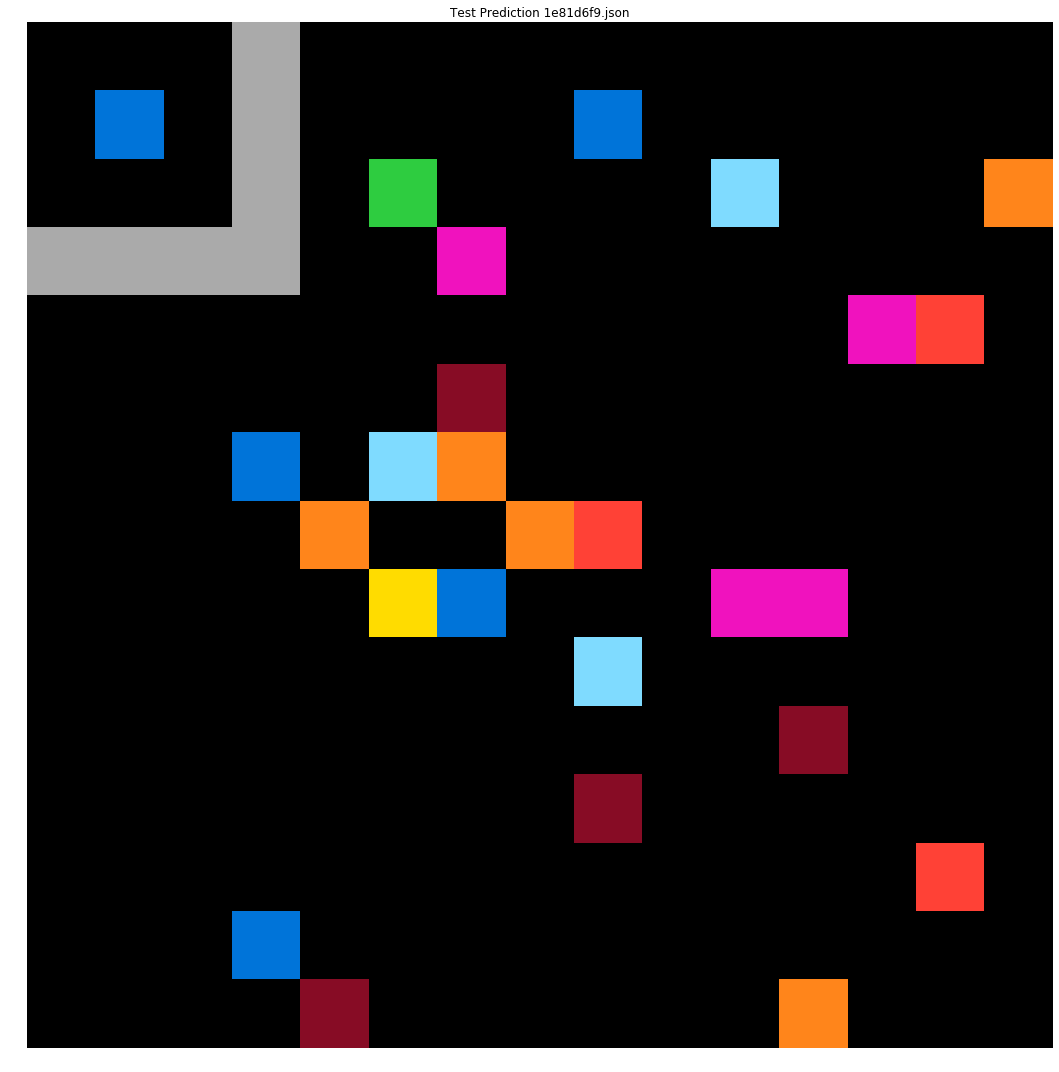

set(val_target) {1, 2, 3, 4, 5, 6, 7, 8}
set(train_target) {1, 2, 3, 4, 5, 6, 7}
Number of colors are not same
cant handle new colors. skipping
Number of input rows: 23 cols: 25
Number of target rows: 3 cols: 7
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/2037f2c7.json

Number of input rows: 3 cols: 3
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/2072aba6.json

Number of input rows: 14 cols: 15
Number of target rows: 6 cols: 8
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/20818e16.json

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    0.7s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.8s finished


Made predictions for  20981f0e


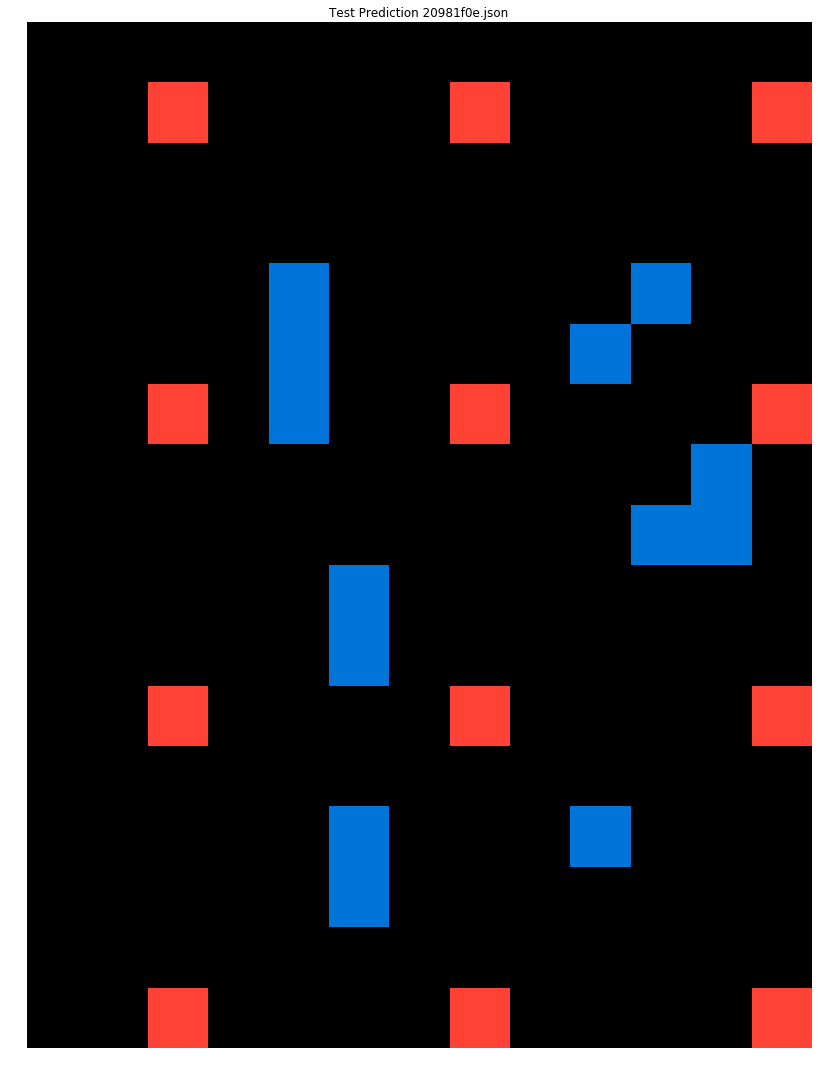

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    1.6s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.8s finished


Made predictions for  212895b5


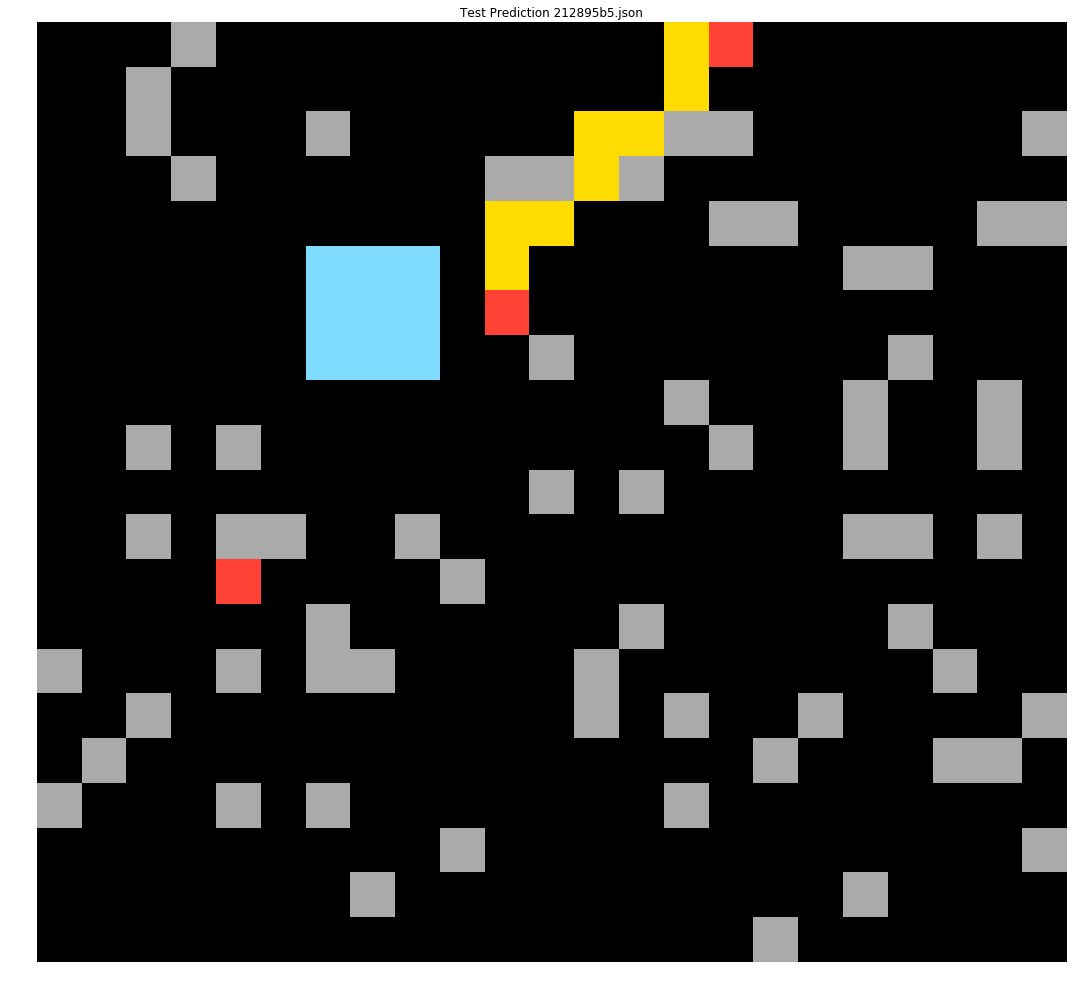

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.6s finished


Made predictions for  21f83797


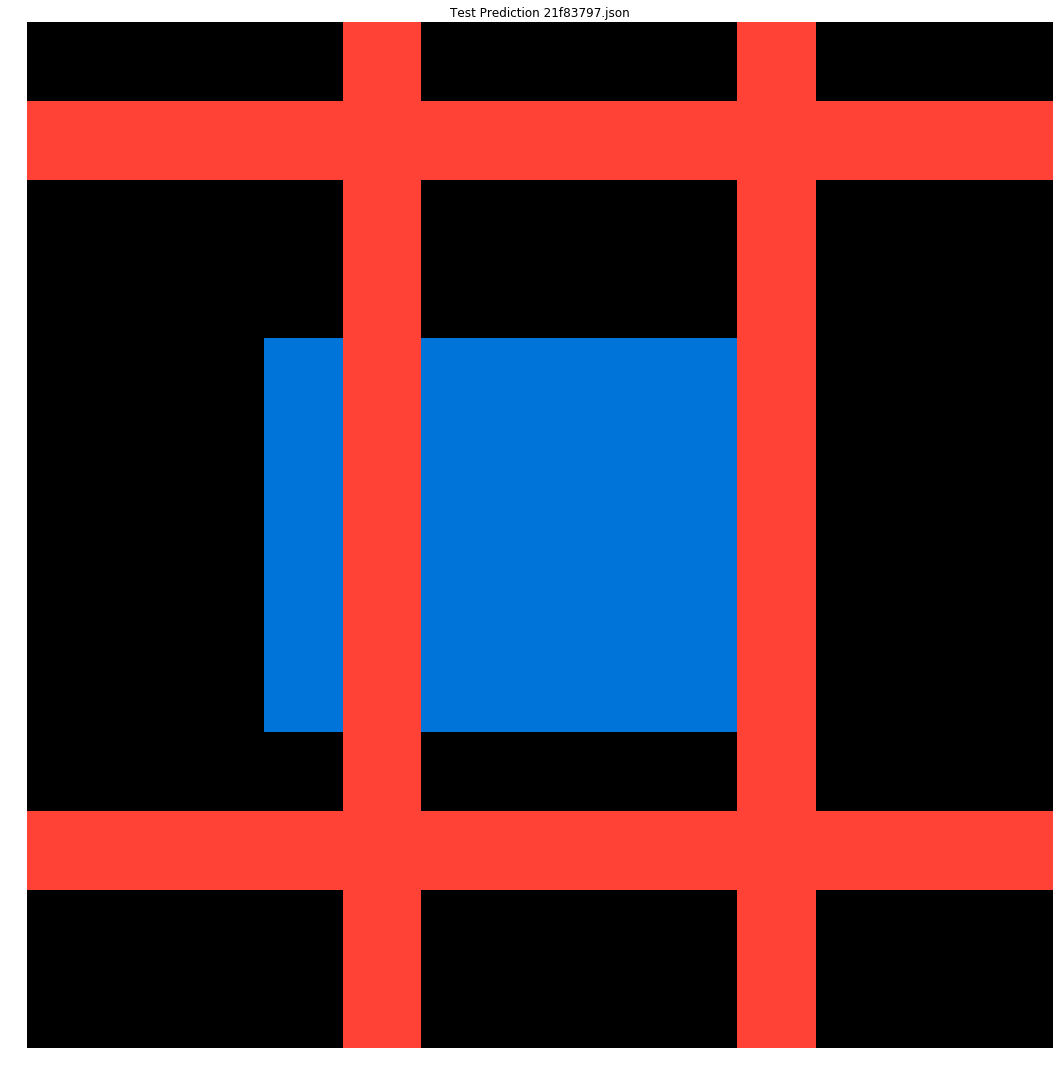

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    0.6s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.7s finished


Made predictions for  22a4bbc2


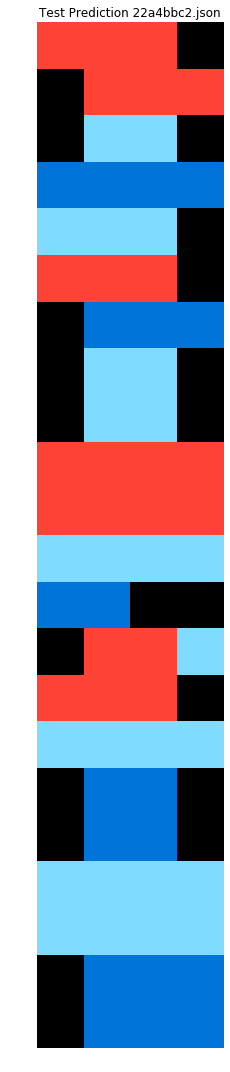

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    3.8s remaining:    1.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    4.2s finished


Made predictions for  25094a63


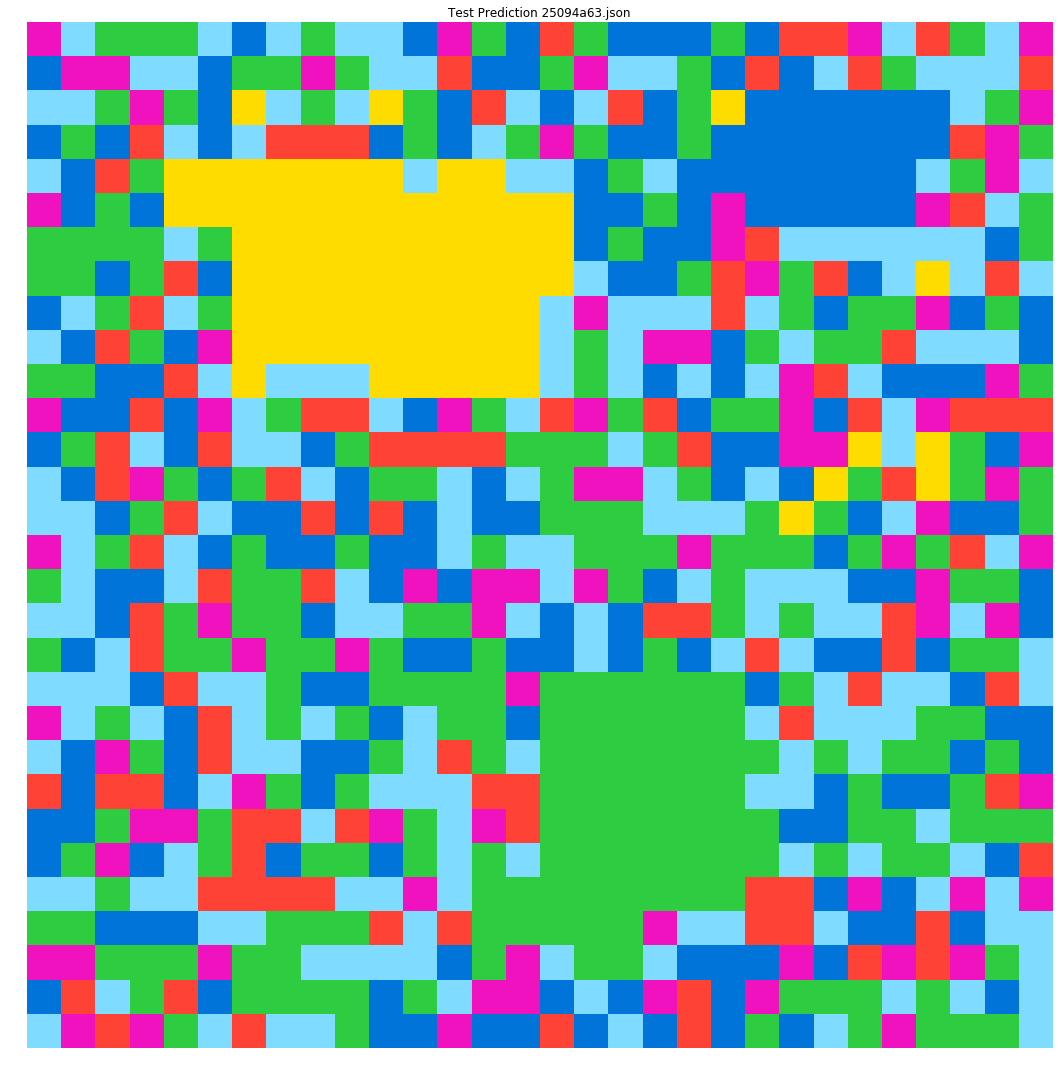

set(val_target) {0, 1, 2, 3}
set(train_target) {0, 4, 6}
Number of colors are not same
cant handle new colors. skipping
Fitting 10 folds for each of 2 candidates, totalling 20 fits


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    5.2s remaining:    1.3s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    5.8s finished


Made predictions for  256b0a75


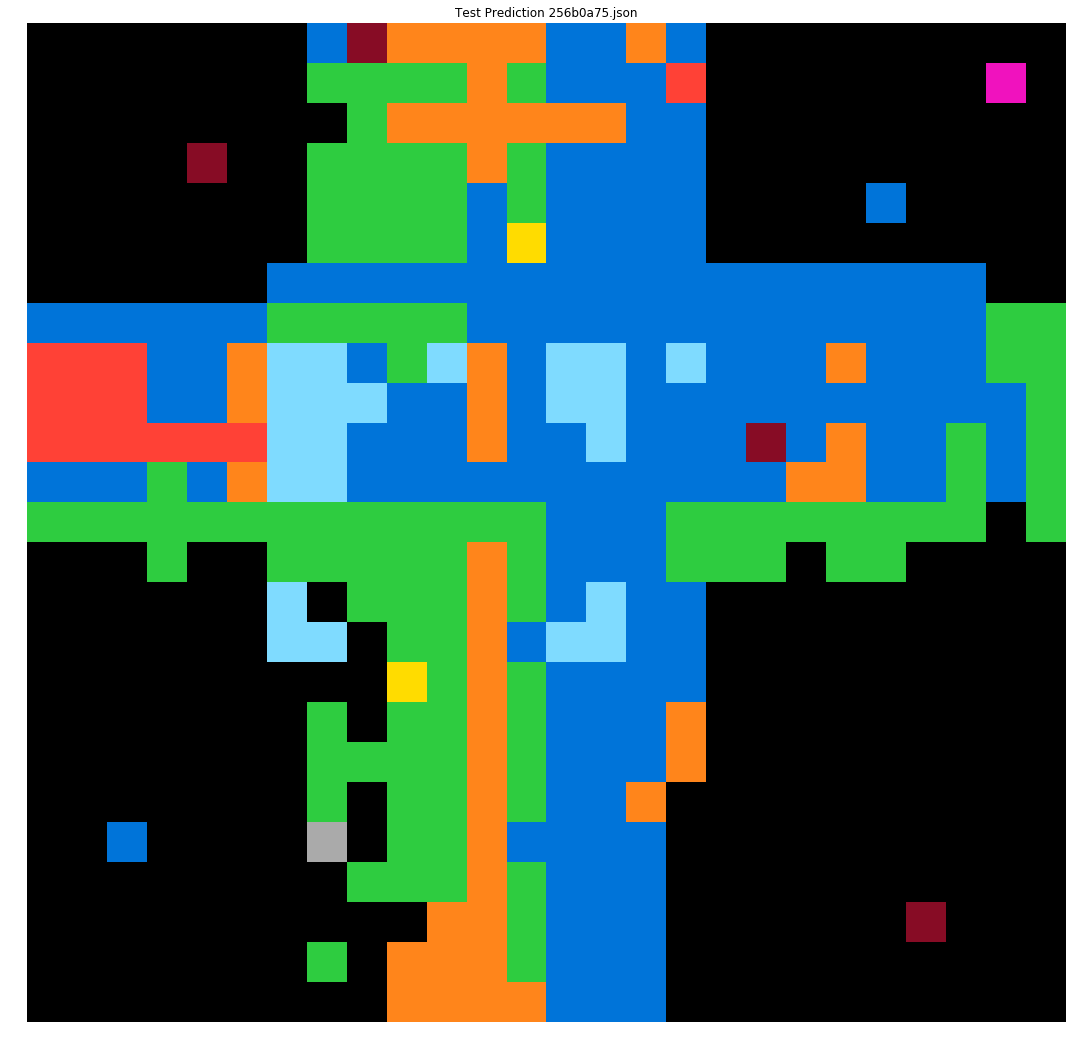

Fitting 10 folds for each of 2 candidates, totalling 20 fits


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    2.0s remaining:    0.5s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    2.3s finished


Made predictions for  2685904e


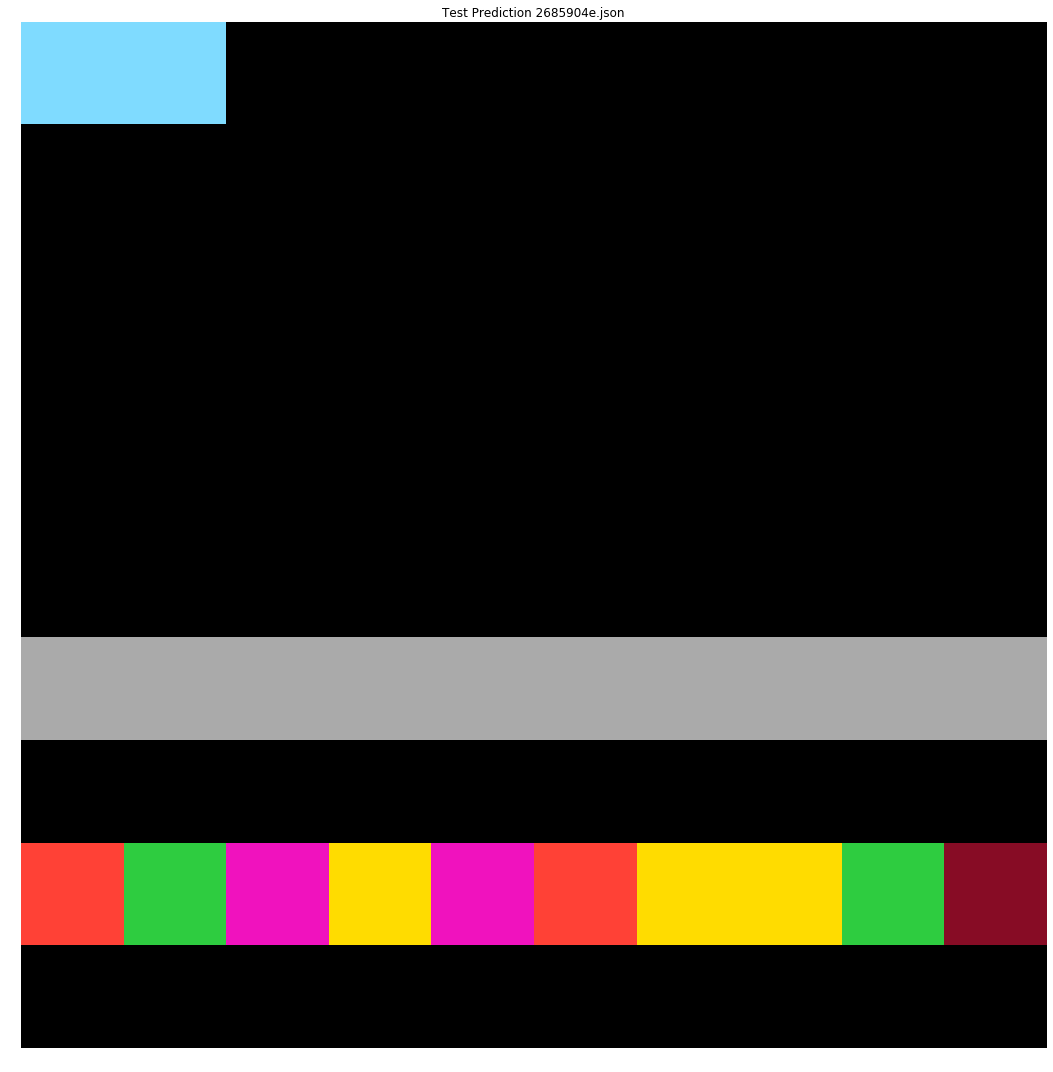

Number of input rows: 9 cols: 7
Number of target rows: 15 cols: 15
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/2697da3f.json

Number of input rows: 16 cols: 16
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/2753e76c.json

set(val_target) {0, 1, 3, 4, 5, 6, 7, 8, 9}
set(train_target) {0, 2, 3, 4, 5, 6, 8}
Number of colors are not same
cant handle new colors. skipping
Number of input rows: 3 cols: 3
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/27f8ce4f.json

Number of input rows: 4 cols: 19
Number of target rows: 4 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/281123b4.json

set(val_target) {9, 2, 1}
set(train_target) {8, 1, 2, 5}
Number of colors are not same
cant handle new colors. skipping
set(val_target) {0, 2, 4, 6}
set(train_target) {0, 3, 5, 6, 8}
Number of colors are not same
cant handle new colors. skipping
set(va

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    1.1s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.2s finished


Made predictions for  2c737e39


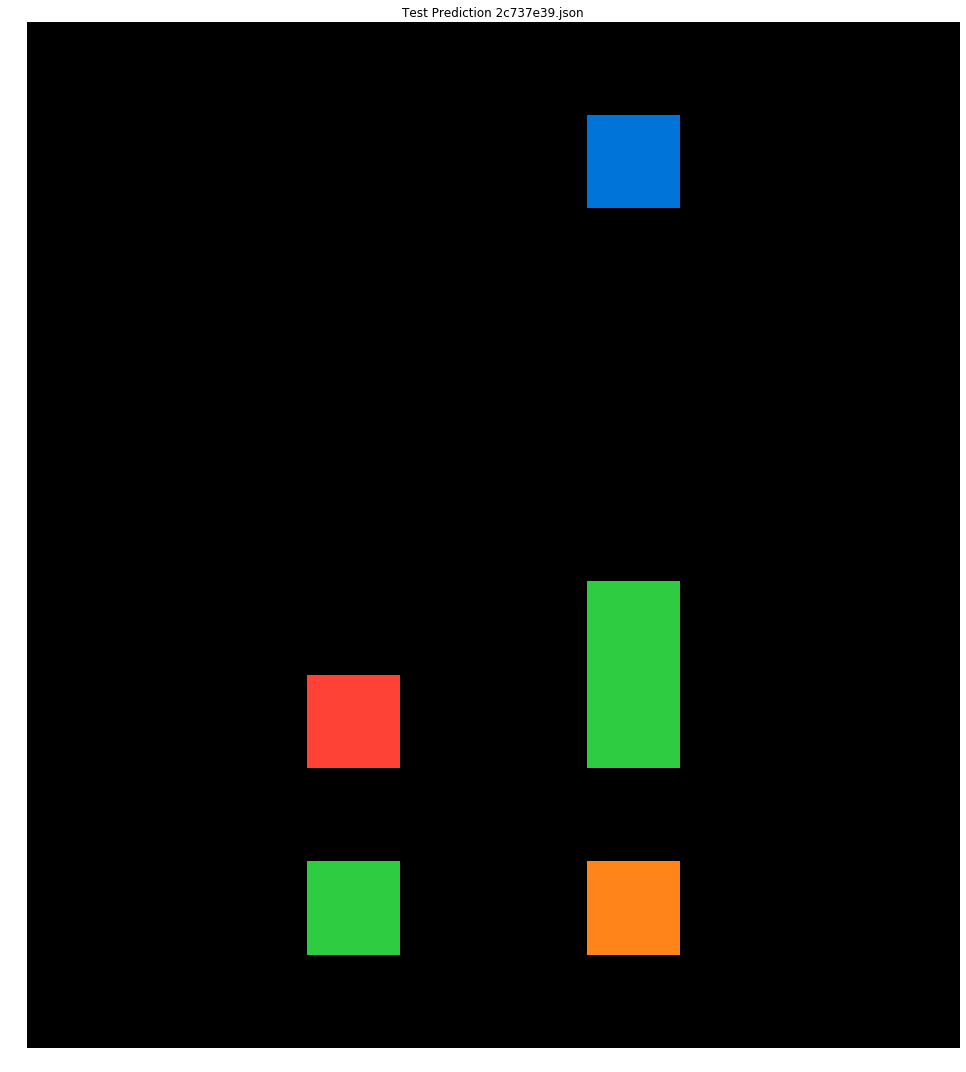

Number of input rows: 20 cols: 23
Number of target rows: 9 cols: 9
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/2f0c5170.json

Number of input rows: 2 cols: 2
Number of target rows: 6 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/310f3251.json

Number of input rows: 20 cols: 20
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/3194b014.json

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    3.8s remaining:    0.9s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    4.5s finished


Made predictions for  319f2597


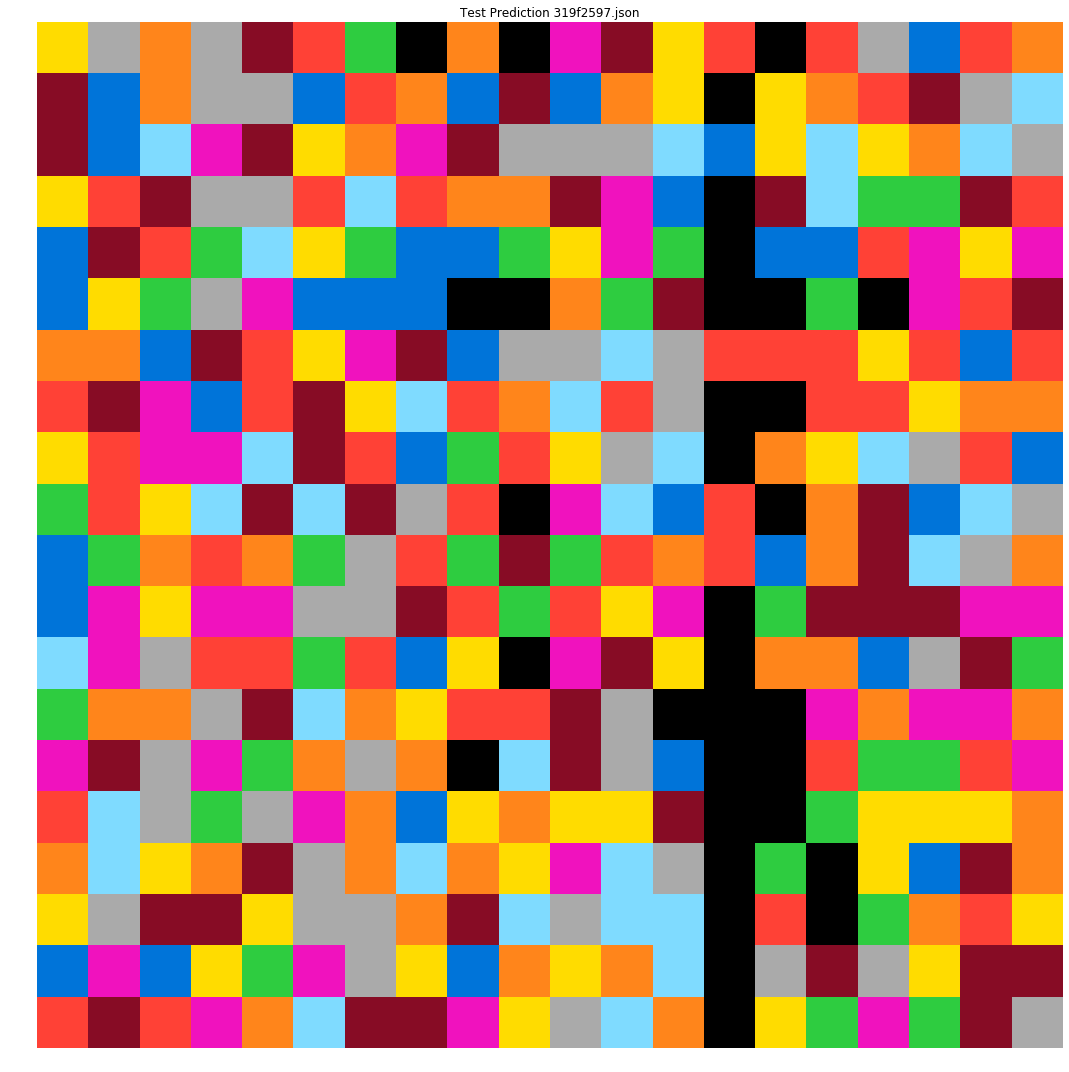

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.5s finished


Made predictions for  31adaf00


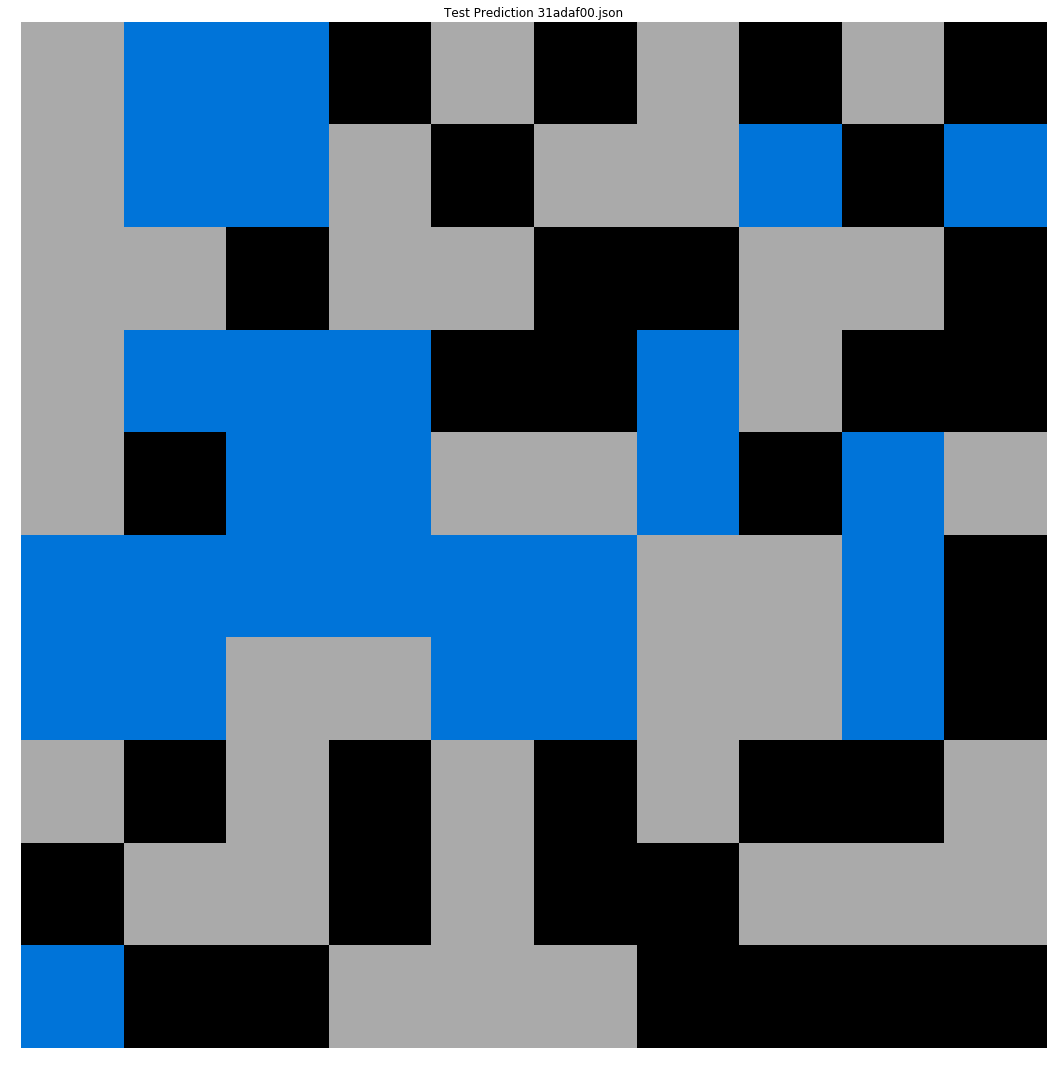

Number of input rows: 6 cols: 5
Number of target rows: 3 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/31d5ba1a.json

set(val_target) {5, 7}
set(train_target) {3, 4, 5}
Number of colors are not same
cant handle new colors. skipping
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.2s finished


Made predictions for  332efdb3


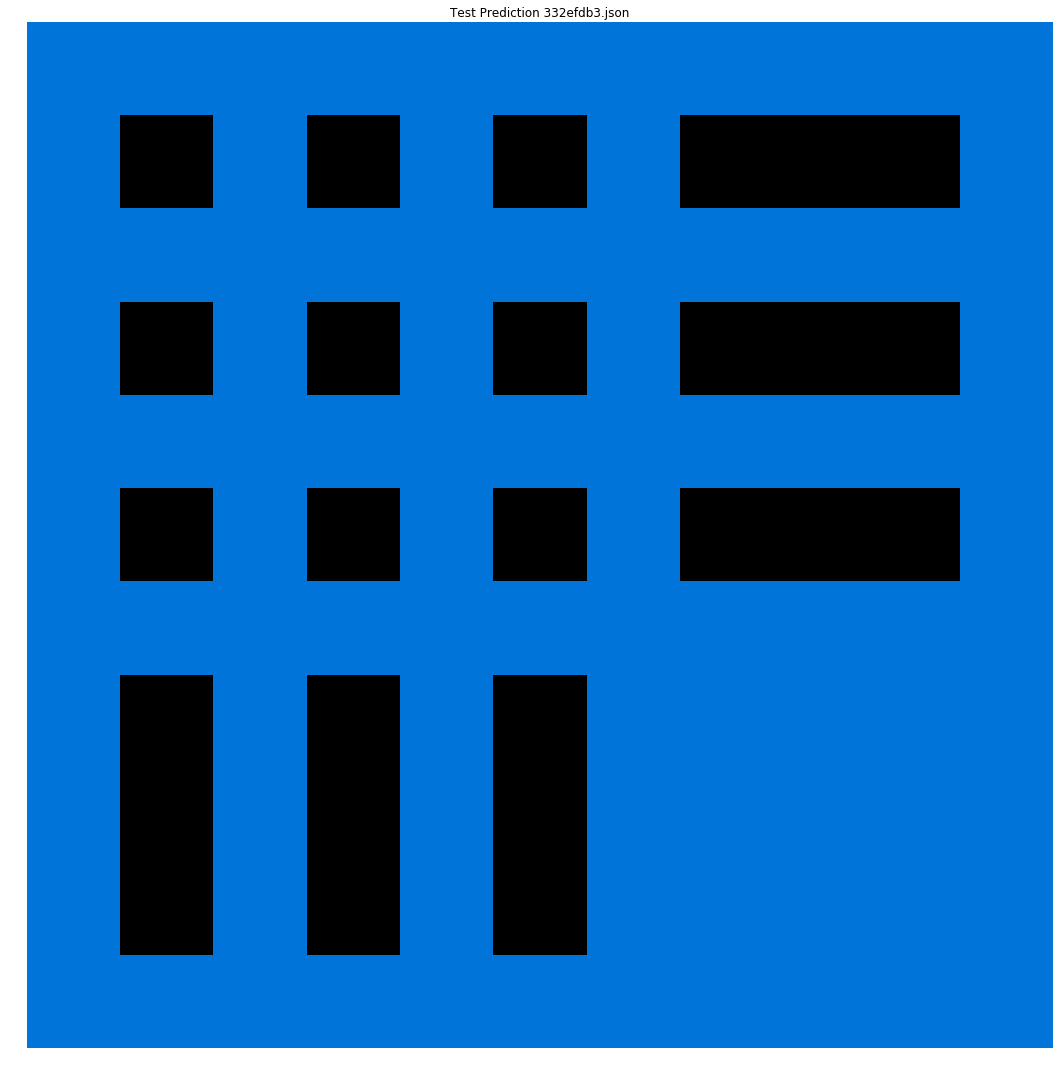

set(val_target) {0, 1, 7}
set(train_target) {0, 1, 2, 3, 8}
Number of colors are not same
cant handle new colors. skipping
set(val_target) {0, 1, 4, 8}
set(train_target) {0, 1, 2, 3}
Number of colors are not same
cant handle new colors. skipping
Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    2.5s remaining:    0.6s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    2.8s finished


Made predictions for  3490cc26


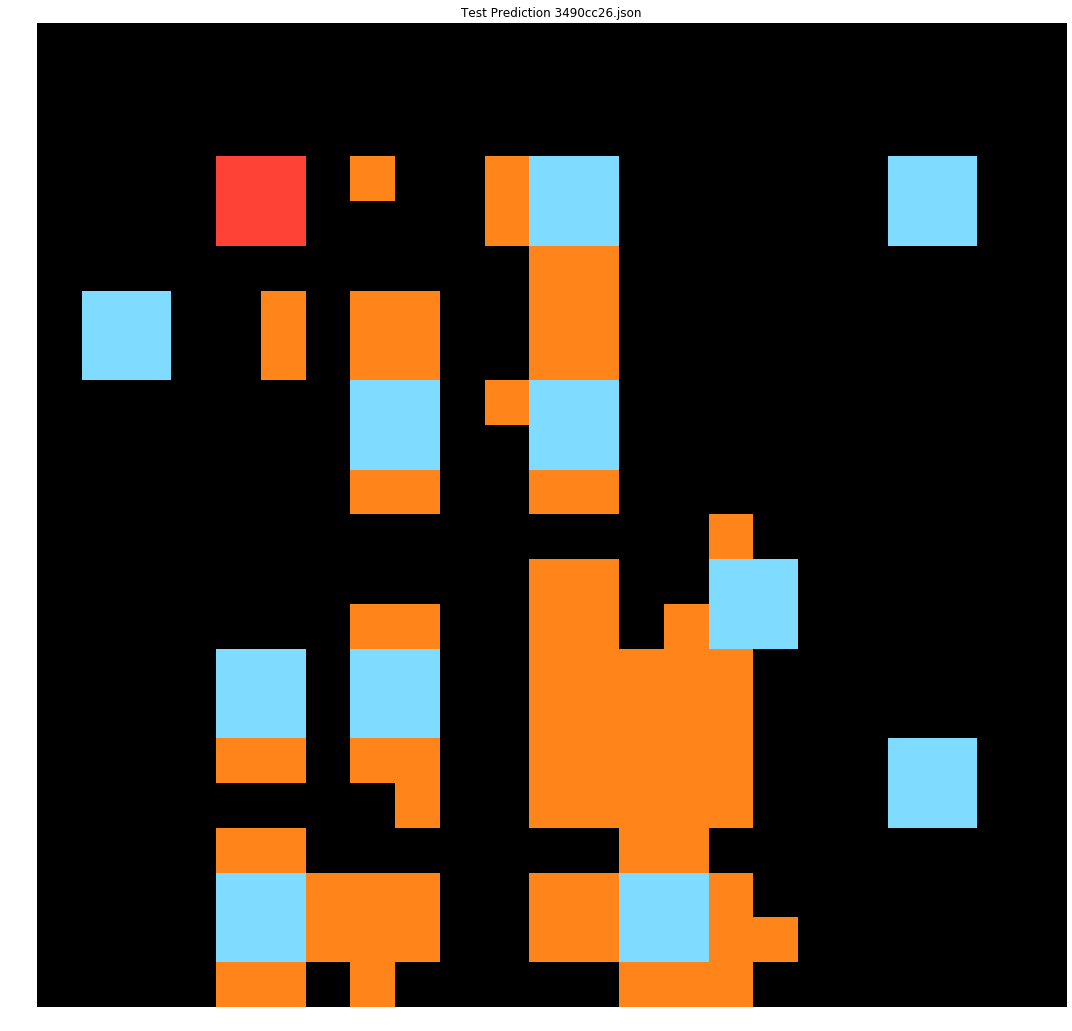

Number of input rows: 5 cols: 9
Number of target rows: 5 cols: 4
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/34b99a2b.json

Number of input rows: 15 cols: 13
Number of target rows: 3 cols: 13
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/351d6448.json

Number of input rows: 14 cols: 18
Number of target rows: 5 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/358ba94e.json

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    1.5s remaining:    0.4s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.7s finished


Made predictions for  37d3e8b2


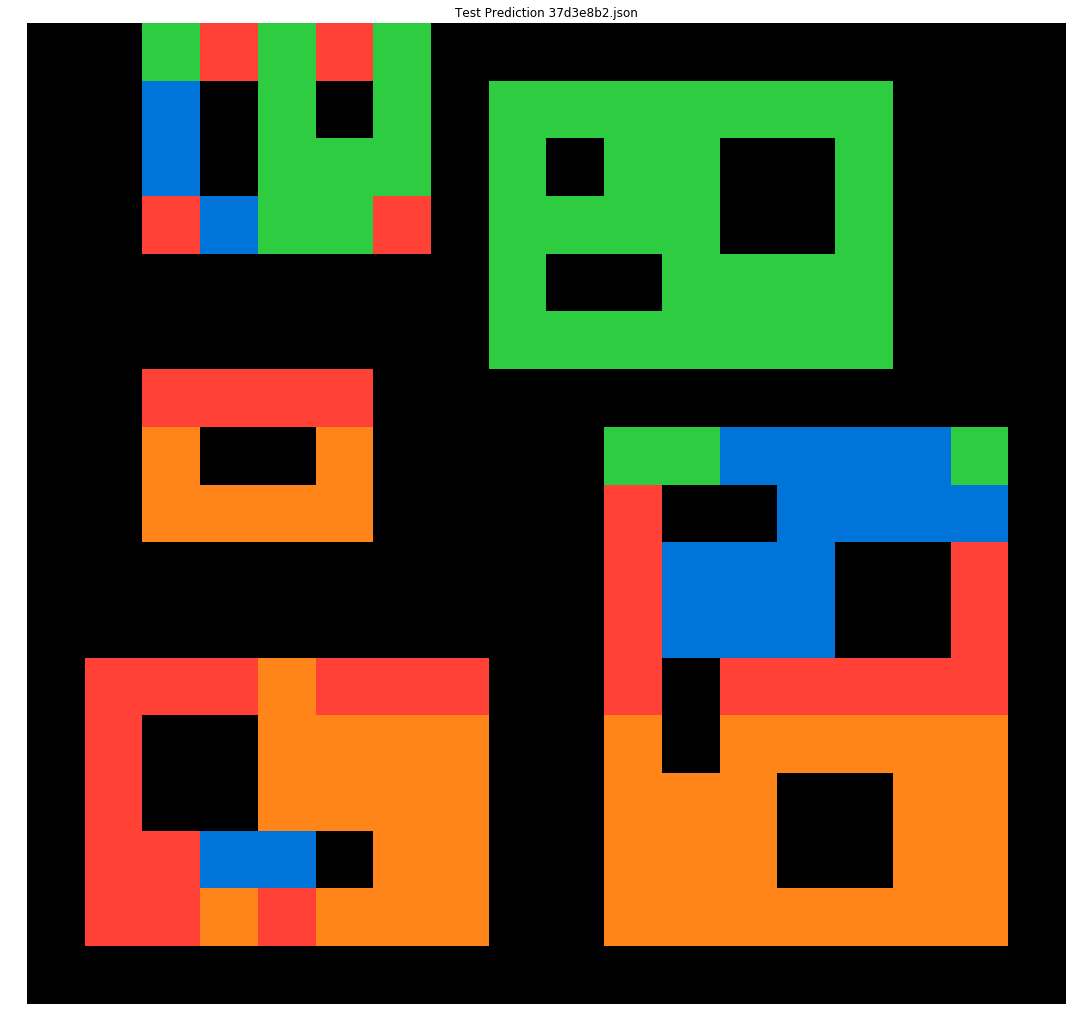

Number of input rows: 5 cols: 5
Number of target rows: 10 cols: 10
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/3979b1a8.json

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    2.3s remaining:    0.6s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    2.7s finished


Made predictions for  3a301edc


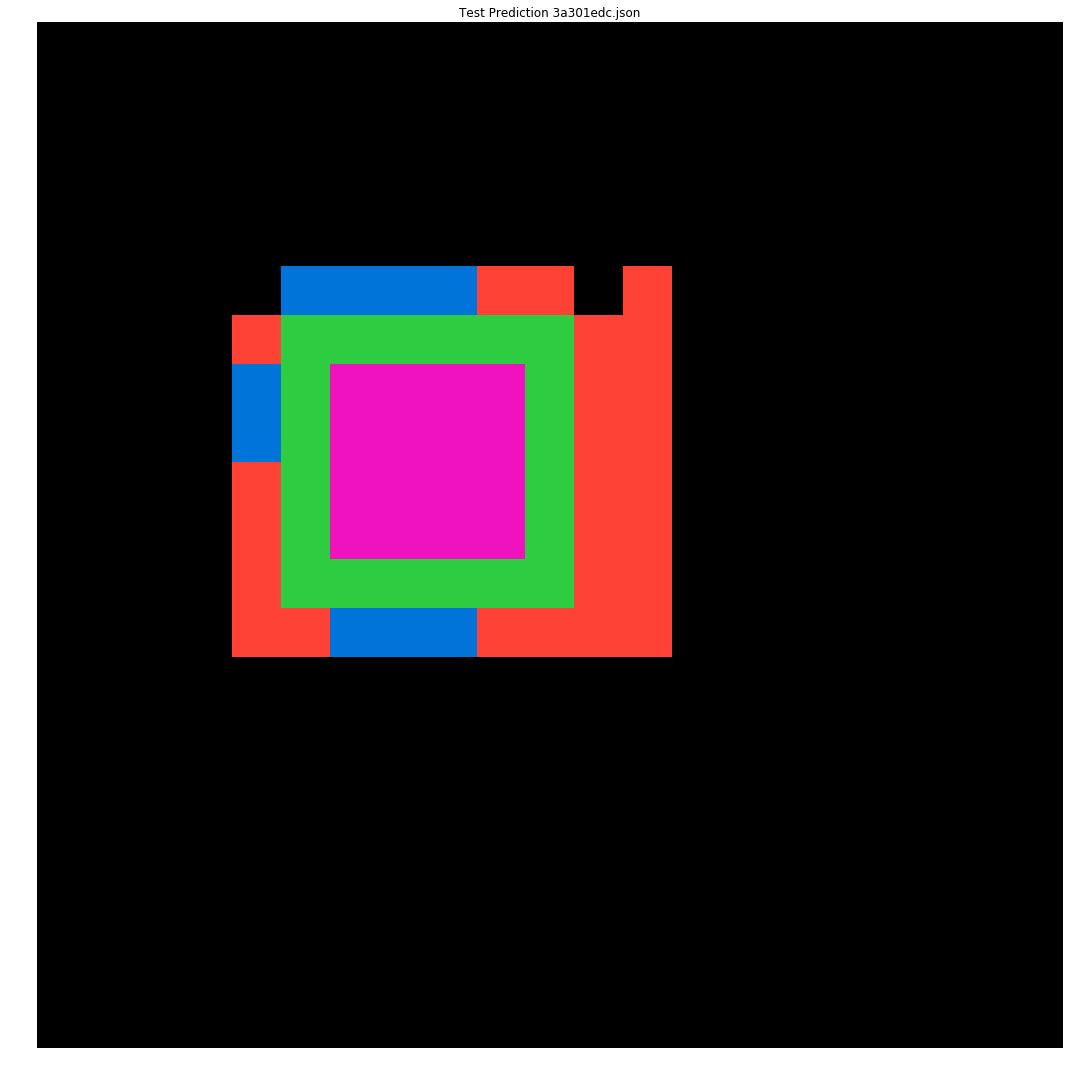

Number of input rows: 7 cols: 7
Number of target rows: 3 cols: 3
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/3b4c2228.json

Number of input rows: 12 cols: 6
Number of target rows: 3 cols: 6
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/3d31c5b3.json

set(val_target) {0, 1, 2, 3, 4, 6, 8}
set(train_target) {0, 1, 2, 3, 4, 8}
Number of colors are not same
cant handle new colors. skipping
Number of input rows: 23 cols: 29
Number of target rows: 5 cols: 5
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/3ee1011a.json

Fitting 10 folds for each of 2 candidates, totalling 20 fits


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=10.
  % (min_groups, self.n_splits)), UserWarning)
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    0.8s remaining:    0.2s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    0.9s finished


Made predictions for  3f23242b


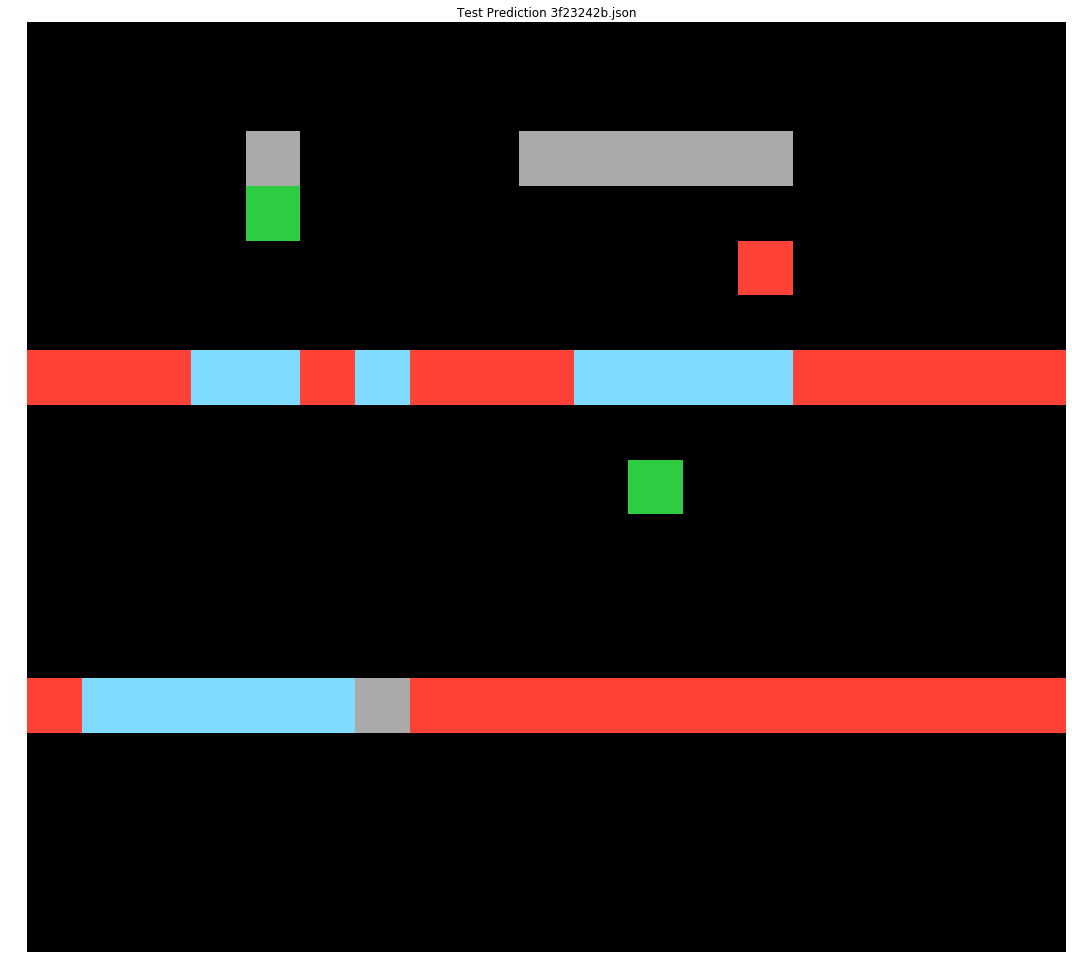

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    5.0s remaining:    1.2s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    6.0s finished


Made predictions for  40f6cd08


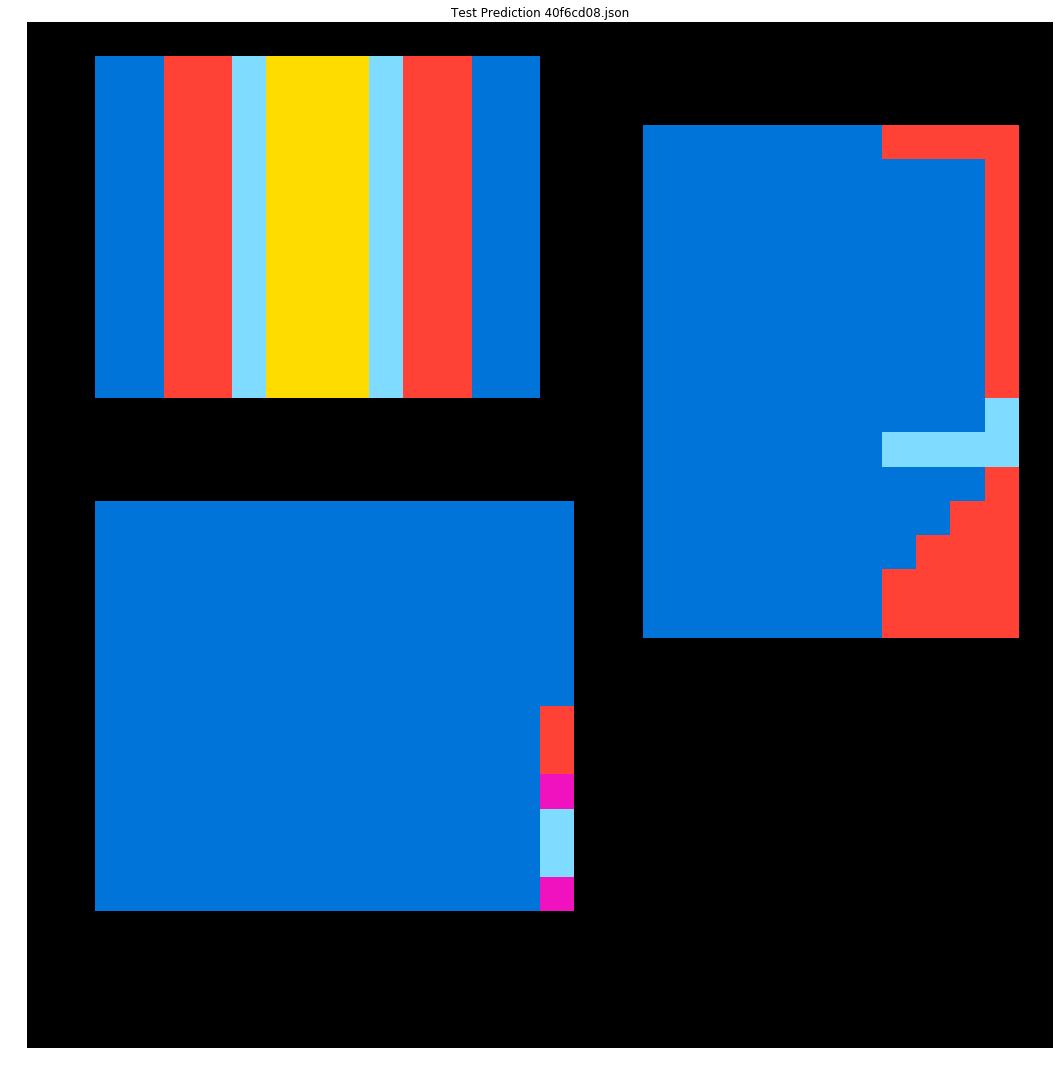

Number of input rows: 18 cols: 22
Number of target rows: 12 cols: 11
ignoring task /kaggle/input/abstraction-and-reasoning-challenge/test/414297c0.json

Fitting 10 folds for each of 2 candidates, totalling 20 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 out of  20 | elapsed:    1.2s remaining:    0.3s
[Parallel(n_jobs=8)]: Done  20 out of  20 | elapsed:    1.3s finished


Made predictions for  423a55dc


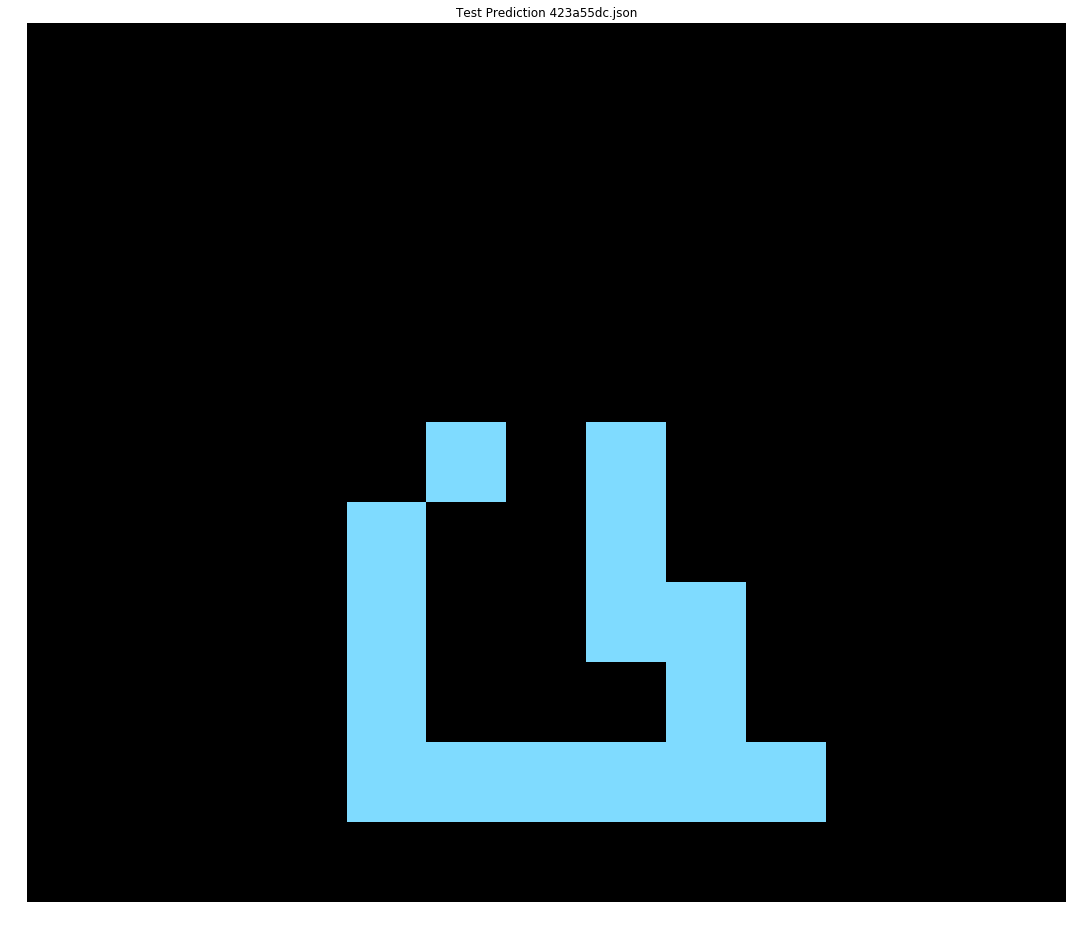

In [9]:
all_task_ids = sorted(os.listdir(test_path))

nfeat = 13
local_neighb = 5
valid_scores = {}
for task_id in all_task_ids:

    task_file = str(test_path / task_id)
    with open(task_file, 'r') as f:
        task = json.load(f)

    feat, target, not_valid = features(task)
    if not_valid:
        print('ignoring task', task_file)
        print()
        not_valid = 0
        continue

    nrows, ncols = len(task['train'][-1]['input']
                       ), len(task['train'][-1]['input'][0])
    # use the last train sample for validation
    val_idx = len(feat) - nrows*ncols

    train_feat = feat[:val_idx]
    val_feat = feat[val_idx:, :]

    train_target = target[:val_idx]
    val_target = target[val_idx:]

    #     check if validation set has a new color
    #     if so make the mapping color independant
    if len(set(val_target) - set(train_target)):
        print('set(val_target)', set(val_target))
        print('set(train_target)', set(train_target))
        print('Number of colors are not same')
        print('cant handle new colors. skipping')
        continue

    xgb = XGBClassifier(n_estimators=100, n_jobs=-1)
   # hgb_pipe = make_pipeline([('xgb', xgb)])


    skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 1001)
    hgb_grid = GridSearchCV(xgb, param_grid, n_jobs=8, 
         cv=skf, verbose=2, refit=True)
    hgb_grid.fit(feat, target)
#     training on input pairs is done.
#     test predictions begins here

    num_test_pairs = len(task['test'])
    for task_num in range(num_test_pairs):
        cur_idx = 0
        input_color = np.array(task['test'][task_num]['input'])
        nrows, ncols = len(task['test'][task_num]['input']), len(
            task['test'][task_num]['input'][0])
        feat = np.zeros((nrows*ncols, nfeat))
        unique_col = {col: i for i, col in enumerate(
            sorted(np.unique(input_color)))}

        for i in range(nrows):
            for j in range(ncols):
                feat[cur_idx, 0] = i
                feat[cur_idx, 1] = j
                feat[cur_idx, 2] = input_color[i][j]
                feat[cur_idx, 3:7] = get_moore_neighbours(
                    input_color, i, j, nrows, ncols)
                feat[cur_idx, 7:9] = get_tl_tr(
                    input_color, i, j, nrows, ncols)
                feat[cur_idx, 9] = len(np.unique(input_color[i, :]))
                feat[cur_idx, 10] = len(np.unique(input_color[:, j]))
                feat[cur_idx, 11] = (i+j)
                feat[cur_idx, 12] = len(np.unique(input_color[i-local_neighb:i+local_neighb,
                                                              j-local_neighb:j+local_neighb]))

                cur_idx += 1

        print('Made predictions for ', task_id[:-5])
        preds = hgb_grid.predict(feat).reshape(nrows, ncols)
        preds = preds.astype(int).tolist()
        plot_test(preds, task_id)
        sample_sub.loc[f'{task_id[:-5]}_{task_num}',
                       'output'] = flattener(preds)


In [10]:
print('\n Best hyperparameters:')
print(hgb_grid.best_params_)


 Best hyperparameters:
{'xgb__early_stopping_rounds': 50, 'xgb__learning_rate': 0.1, 'xgb__n_estimators': 10}


In [11]:
sample_sub.head()

,output
output_id,
00576224_0,|32|78| |32|78| |00|00|
009d5c81_0,|00000000000000|00000277227777|00000200020307|...
00dbd492_0,|00000000000222220000|02222222223233323300|028...
03560426_0,|4144000000|1140000000|8002000000|0002000000|0...
05a7bcf2_0,|000000000020000000080000000000|00000044488888...


In [12]:
sample_sub.to_csv('submission.csv')